# Going Deeper 01. ResNet Ablation Study
--------
## [루브릭]

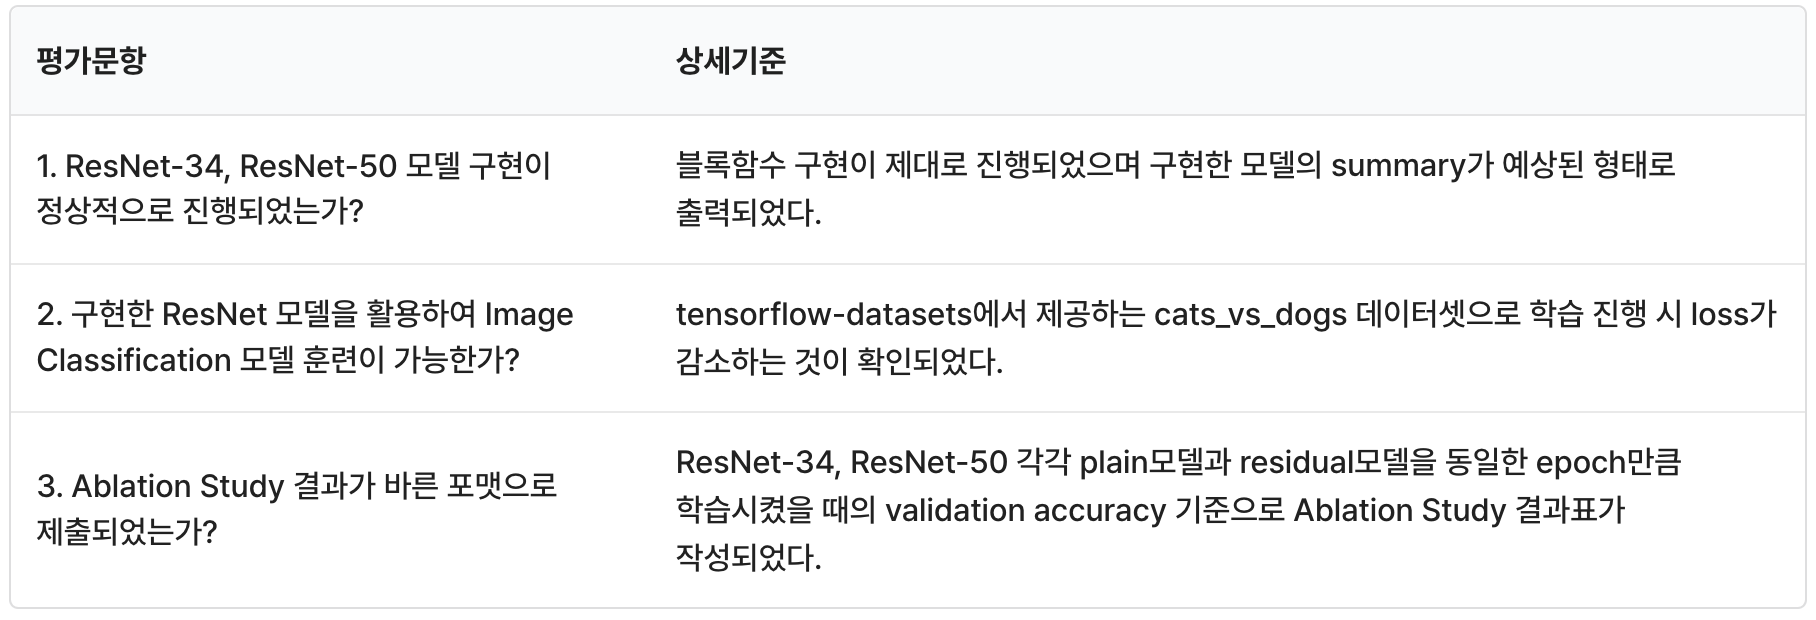

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.keras.backend.clear_session()

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' ## 초기화할 GPU number

with tf.Graph().as_default():
	# GPU 메모리를 전부 할당하지 않고, 아주 적은 비율만 할당되어 시작됨. 프로세스의 메모리 수요에 따라 자동적으로 증가
	# 단, GPU 메모리를 처음부터 전체 비율을 사용하지 않음
	gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

In [6]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [9]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [10]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_validation))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


In [11]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
ds_info.features["label"].num_classes

2

In [14]:
ds_info.features["label"].names

['cat', 'dog']

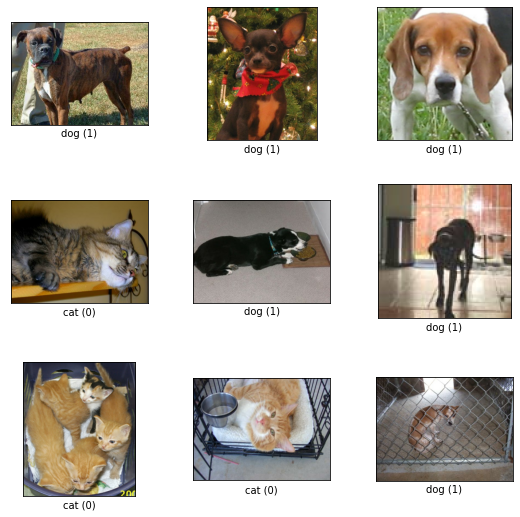

In [15]:
fig = tfds.show_examples(ds_train, ds_info)

In [16]:
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [17]:
# is_50 : True => resnet_50
# is_plain : True => no skip connection
# original skip connection
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=0, is_50=False, is_plain=False):
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    if not is_50:
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  
#             x = keras.layers.Conv2D(
#                 filters=channel,
#                 kernel_size=(3,3),
#                 kernel_initializer='he_normal',
#                 padding='same',
#                 name=f'block{block_num}_0_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            
            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]
                
#                 if shortcut_channel != channel:
#                     shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_2_shortcut{cnn_num}')(shortcut)
#                     shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)

                if (shortcut_channel != channel) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                    
                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_2_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
            
            else:
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
    
    else :
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  
 
            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_1_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='valid',
                name=f'block{block_num}_2_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(x)        

            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]

                if (shortcut_channel != channel*4) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel*4) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)

                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_3_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)

            else :
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)
        
    return x

In [18]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
res_block_output = build_resnet_block(resnet_input_layer)    # resnet block 생성

In [19]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=res_block_output)  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block0_0_conv0 (Conv2D)         (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block0_0_bn0 (BatchNormalizatio (None, 32, 32, 64)   256         block0_0_conv0[0][0]             
__________________________________________________________________________________________________
block0_0_relu0 (Activation)     (None, 32, 32, 64)   0           block0_0_bn0[0][0]               
______________________________________________________________________________________________

In [71]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=2, is_50=False, is_plain=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # conv 1층
    output = keras.layers.Conv2D(filters=channel_list[0],
                                kernel_size=(7,7),
                                strides=(2,2),
                                padding='same',
                                kernel_initializer='he_normal')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    # conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i, 
            is_50=is_50,
            is_plain=is_plain
        )
        
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [21]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_50 = build_resnet(is_50=True)

resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

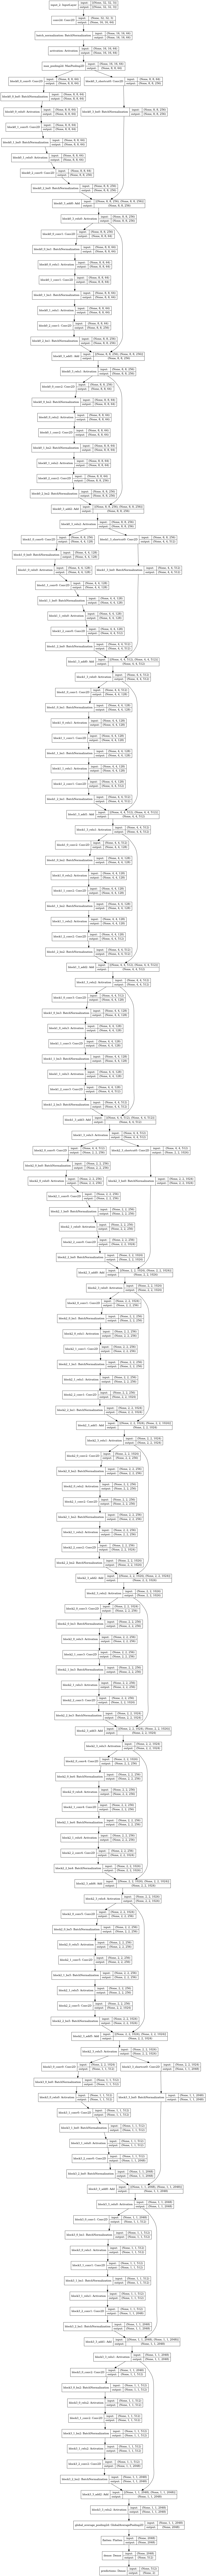

In [78]:
from tensorflow.keras.utils import plot_model

plot_model(resnet_50, show_shapes=True, to_file='resnet_50.png')

In [22]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_34 = build_resnet(is_50=False)

resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [24]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_validation = apply_normalize_on_dataset(ds_validation, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [50]:
BATCH_SIZE = 64
EPOCH = 50

In [51]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 61/290 [=====>........................] - ETA: 13s - loss: 0.1579 - accuracy: 0.9421

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 13s - loss: 0.1558 - accuracy: 0.9426

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 13s - loss: 0.1543 - accuracy: 0.9426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 12s - loss: 0.1514 - accuracy: 0.9430

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 5s - loss: 0.1563 - accuracy: 0.9392

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 4s - loss: 0.1561 - accuracy: 0.9395

212/290 [====================>.........] - ETA: 4s - loss: 0.1567 - accuracy: 0.9391

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 0.1595 - accuracy: 0.9376

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9392

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 38s 90ms/step - loss: 0.1578 - accuracy: 0.9392 - val_loss: 1.6108 - val_accuracy: 0.6981


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/50
 62/290 [=====>........................] - ETA: 13s - loss: 0.2366 - accuracy: 0.9120

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 13s - loss: 0.2513 - accuracy: 0.9024

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 12s - loss: 0.2585 - accuracy: 0.9001

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 12s - loss: 0.2716 - accuracy: 0.8930

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 5s - loss: 0.2533 - accuracy: 0.8974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 0.2461 - accuracy: 0.9008

213/290 [=====================>........] - ETA: 4s - loss: 0.2438 - accuracy: 0.9018

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.2320 - accuracy: 0.9065

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9115

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.2208 - accuracy: 0.9115 - val_loss: 1.0764 - val_accuracy: 0.7121


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/50
 63/290 [=====>........................] - ETA: 13s - loss: 0.1409 - accuracy: 0.9459

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 12s - loss: 0.1390 - accuracy: 0.9453

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 12s - loss: 0.1378 - accuracy: 0.9463

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 11s - loss: 0.1361 - accuracy: 0.9467

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 11s - loss: 0.1361 - accuracy: 0.9466

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 5s - loss: 0.1368 - accuracy: 0.9456

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.1354 - accuracy: 0.9462

214/290 [=====================>........] - ETA: 4s - loss: 0.1349 - accuracy: 0.9465

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.1334 - accuracy: 0.9471

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9485

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.1312 - accuracy: 0.9485 - val_loss: 1.1506 - val_accuracy: 0.6965


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/50
 64/290 [=====>........................] - ETA: 13s - loss: 0.1118 - accuracy: 0.9580

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 12s - loss: 0.1149 - accuracy: 0.9573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 12s - loss: 0.1157 - accuracy: 0.9570

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 11s - loss: 0.1141 - accuracy: 0.9575

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 5s - loss: 0.1023 - accuracy: 0.9619

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 0.1015 - accuracy: 0.9620

215/290 [=====================>........] - ETA: 4s - loss: 0.1021 - accuracy: 0.9620

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.1032 - accuracy: 0.9609

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9597

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.1061 - accuracy: 0.9597 - val_loss: 0.9307 - val_accuracy: 0.7344


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/50
 65/290 [=====>........................] - ETA: 13s - loss: 0.0930 - accuracy: 0.9639

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 12s - loss: 0.0937 - accuracy: 0.9633

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 12s - loss: 0.0957 - accuracy: 0.9627

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 11s - loss: 0.0971 - accuracy: 0.9620

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 5s - loss: 0.1013 - accuracy: 0.9600

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.1036 - accuracy: 0.9591

216/290 [=====================>........] - ETA: 4s - loss: 0.1035 - accuracy: 0.9596

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.1037 - accuracy: 0.9596

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9599

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.1042 - accuracy: 0.9599 - val_loss: 1.0859 - val_accuracy: 0.7361


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 6/50
 66/290 [=====>........................] - ETA: 13s - loss: 0.1237 - accuracy: 0.9524

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 12s - loss: 0.1187 - accuracy: 0.9544

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 12s - loss: 0.1157 - accuracy: 0.9555

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 11s - loss: 0.1136 - accuracy: 0.9562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 5s - loss: 0.1023 - accuracy: 0.9617

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 4s - loss: 0.1042 - accuracy: 0.9605

217/290 [=====================>........] - ETA: 4s - loss: 0.1035 - accuracy: 0.9610

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 2s - loss: 0.1023 - accuracy: 0.9611

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9613

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.1016 - accuracy: 0.9613 - val_loss: 1.1844 - val_accuracy: 0.7339


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 7/50
 67/290 [=====>........................] - ETA: 12s - loss: 0.0859 - accuracy: 0.9674

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 12s - loss: 0.0862 - accuracy: 0.9675

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 12s - loss: 0.0856 - accuracy: 0.9676

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 11s - loss: 0.0829 - accuracy: 0.9696

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 5s - loss: 0.0875 - accuracy: 0.9671

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 4s - loss: 0.0859 - accuracy: 0.9679

218/290 [=====================>........] - ETA: 4s - loss: 0.0851 - accuracy: 0.9682

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 2s - loss: 0.0879 - accuracy: 0.9672

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9675

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0867 - accuracy: 0.9675 - val_loss: 1.3568 - val_accuracy: 0.7246


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 8/50
 68/290 [======>.......................] - ETA: 13s - loss: 0.0887 - accuracy: 0.9660

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 12s - loss: 0.0894 - accuracy: 0.9660

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 12s - loss: 0.0873 - accuracy: 0.9670

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 11s - loss: 0.0880 - accuracy: 0.9671

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 5s - loss: 0.0880 - accuracy: 0.9672

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 4s - loss: 0.0879 - accuracy: 0.9673

219/290 [=====================>........] - ETA: 4s - loss: 0.0893 - accuracy: 0.9670

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 2s - loss: 0.0891 - accuracy: 0.9667

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9666

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0888 - accuracy: 0.9666 - val_loss: 1.1424 - val_accuracy: 0.7277


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 9/50
 69/290 [======>.......................] - ETA: 13s - loss: 0.0762 - accuracy: 0.9717

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 12s - loss: 0.0774 - accuracy: 0.9716

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 12s - loss: 0.0781 - accuracy: 0.9713

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 11s - loss: 0.0787 - accuracy: 0.9719

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 5s - loss: 0.0792 - accuracy: 0.9724

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 4s - loss: 0.0809 - accuracy: 0.9719

220/290 [=====================>........] - ETA: 4s - loss: 0.0803 - accuracy: 0.9722

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.0820 - accuracy: 0.9707

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9707

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.0805 - accuracy: 0.9707 - val_loss: 1.1516 - val_accuracy: 0.7253


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 10/50
 71/290 [======>.......................] - ETA: 12s - loss: 0.0769 - accuracy: 0.9685

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 0.0776 - accuracy: 0.9683

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 11s - loss: 0.0767 - accuracy: 0.9688

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9686

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 0.0805 - accuracy: 0.9678

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 4s - loss: 0.0826 - accuracy: 0.9674

221/290 [=====================>........] - ETA: 3s - loss: 0.0819 - accuracy: 0.9679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.0792 - accuracy: 0.9692

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9688

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 80ms/step - loss: 0.0808 - accuracy: 0.9688 - val_loss: 1.1412 - val_accuracy: 0.7339


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 11/50
 71/290 [======>.......................] - ETA: 11s - loss: 0.2276 - accuracy: 0.9196

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 11s - loss: 0.2217 - accuracy: 0.9211

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 11s - loss: 0.2179 - accuracy: 0.9220

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 0.2081 - accuracy: 0.9246

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 4s - loss: 0.1527 - accuracy: 0.9445

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.1508 - accuracy: 0.9452

222/290 [=====================>........] - ETA: 3s - loss: 0.1507 - accuracy: 0.9451

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.1450 - accuracy: 0.9469

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9323

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 81ms/step - loss: 0.1761 - accuracy: 0.9323 - val_loss: 1.0313 - val_accuracy: 0.6016


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 12/50
 72/290 [======>.......................] - ETA: 12s - loss: 0.3112 - accuracy: 0.8685

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 12s - loss: 0.3025 - accuracy: 0.8726

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 11s - loss: 0.2969 - accuracy: 0.8752

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 11s - loss: 0.2805 - accuracy: 0.8826

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 5s - loss: 0.2314 - accuracy: 0.9052

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 4s - loss: 0.2234 - accuracy: 0.9092

223/290 [======================>.......] - ETA: 3s - loss: 0.2214 - accuracy: 0.9104

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.2064 - accuracy: 0.9170

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1973 - accuracy: 0.9212

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.1973 - accuracy: 0.9212 - val_loss: 0.9200 - val_accuracy: 0.7432


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 13/50
 74/290 [======>.......................] - ETA: 12s - loss: 0.1131 - accuracy: 0.9630

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 11s - loss: 0.1103 - accuracy: 0.9641

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 11s - loss: 0.1090 - accuracy: 0.9638

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 10s - loss: 0.1020 - accuracy: 0.9657

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.0899 - accuracy: 0.9676

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 4s - loss: 0.0878 - accuracy: 0.9680

224/290 [======================>.......] - ETA: 3s - loss: 0.0881 - accuracy: 0.9680

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.0907 - accuracy: 0.9668

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9678

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0880 - accuracy: 0.9678 - val_loss: 0.9918 - val_accuracy: 0.7563


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 14/50
 75/290 [======>.......................] - ETA: 12s - loss: 0.0759 - accuracy: 0.9748

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 11s - loss: 0.0788 - accuracy: 0.9724

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 11s - loss: 0.0779 - accuracy: 0.9727

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 10s - loss: 0.0771 - accuracy: 0.9722

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 4s - loss: 0.0736 - accuracy: 0.9735

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.0719 - accuracy: 0.9742

225/290 [======================>.......] - ETA: 3s - loss: 0.0712 - accuracy: 0.9745

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.0665 - accuracy: 0.9761

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9759

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0661 - accuracy: 0.9759 - val_loss: 1.5241 - val_accuracy: 0.7179


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 15/50
 76/290 [======>.......................] - ETA: 12s - loss: 0.0677 - accuracy: 0.9773

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 11s - loss: 0.0683 - accuracy: 0.9769

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 11s - loss: 0.0680 - accuracy: 0.9766

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 10s - loss: 0.0666 - accuracy: 0.9772

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 0.0611 - accuracy: 0.9779

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 3s - loss: 0.0613 - accuracy: 0.9779

226/290 [======================>.......] - ETA: 3s - loss: 0.0606 - accuracy: 0.9782

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.0621 - accuracy: 0.9780

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9785

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0608 - accuracy: 0.9785 - val_loss: 1.3536 - val_accuracy: 0.7218


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 16/50
 76/290 [======>.......................] - ETA: 12s - loss: 0.0495 - accuracy: 0.9803

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 11s - loss: 0.0485 - accuracy: 0.9806

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9810

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 10s - loss: 0.0493 - accuracy: 0.9798

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 0.0460 - accuracy: 0.9823

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 3s - loss: 0.0459 - accuracy: 0.9823

227/290 [======================>.......] - ETA: 3s - loss: 0.0458 - accuracy: 0.9823

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.0467 - accuracy: 0.9823

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9823

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.0468 - accuracy: 0.9823 - val_loss: 1.1046 - val_accuracy: 0.7559


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 17/50
 77/290 [======>.......................] - ETA: 12s - loss: 0.0490 - accuracy: 0.9862

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9864

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 11s - loss: 0.0483 - accuracy: 0.9856

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9856

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 4s - loss: 0.0526 - accuracy: 0.9825

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 0.0526 - accuracy: 0.9828

228/290 [======================>.......] - ETA: 3s - loss: 0.0531 - accuracy: 0.9824

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0548 - accuracy: 0.9815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9818

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 82ms/step - loss: 0.0538 - accuracy: 0.9818 - val_loss: 1.2005 - val_accuracy: 0.7087


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 18/50
 78/290 [=======>......................] - ETA: 12s - loss: 0.0351 - accuracy: 0.9874

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 11s - loss: 0.0357 - accuracy: 0.9873

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 11s - loss: 0.0356 - accuracy: 0.9875

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 10s - loss: 0.0385 - accuracy: 0.9867

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 0.0396 - accuracy: 0.9859

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 3s - loss: 0.0400 - accuracy: 0.9862

229/290 [======================>.......] - ETA: 3s - loss: 0.0401 - accuracy: 0.9863

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.0421 - accuracy: 0.9853

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0428 - accuracy: 0.9852 - val_loss: 1.1941 - val_accuracy: 0.7321


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 19/50
 79/290 [=======>......................] - ETA: 11s - loss: 0.0567 - accuracy: 0.9784

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 11s - loss: 0.0599 - accuracy: 0.9771

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 11s - loss: 0.0591 - accuracy: 0.9777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 10s - loss: 0.0569 - accuracy: 0.9781

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.0525 - accuracy: 0.9797

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 3s - loss: 0.0536 - accuracy: 0.9794

230/290 [======================>.......] - ETA: 3s - loss: 0.0534 - accuracy: 0.9794

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 1s - loss: 0.0528 - accuracy: 0.9797

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9805

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0511 - accuracy: 0.9805 - val_loss: 1.1240 - val_accuracy: 0.7560


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 20/50
 80/290 [=======>......................] - ETA: 11s - loss: 0.0493 - accuracy: 0.9824

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 11s - loss: 0.0482 - accuracy: 0.9829

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 11s - loss: 0.0482 - accuracy: 0.9823

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 10s - loss: 0.0526 - accuracy: 0.9820

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 0.0494 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 3s - loss: 0.0500 - accuracy: 0.9826

231/290 [======================>.......] - ETA: 3s - loss: 0.0497 - accuracy: 0.9825

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


267/290 [==========================>...] - ETA: 1s - loss: 0.0508 - accuracy: 0.9818

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9825

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 82ms/step - loss: 0.0491 - accuracy: 0.9825 - val_loss: 1.4387 - val_accuracy: 0.7126


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 21/50
 82/290 [=======>......................] - ETA: 11s - loss: 0.0536 - accuracy: 0.9802

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 11s - loss: 0.0527 - accuracy: 0.9808

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 11s - loss: 0.0517 - accuracy: 0.9812

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 10s - loss: 0.0505 - accuracy: 0.9817

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.0471 - accuracy: 0.9830

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 3s - loss: 0.0484 - accuracy: 0.9824

232/290 [=======================>......] - ETA: 3s - loss: 0.0480 - accuracy: 0.9826

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.0492 - accuracy: 0.9826

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9820

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0495 - accuracy: 0.9820 - val_loss: 1.2013 - val_accuracy: 0.7361


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 22/50
 83/290 [=======>......................] - ETA: 11s - loss: 0.0442 - accuracy: 0.9842

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 11s - loss: 0.0430 - accuracy: 0.9847

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 10s - loss: 0.0435 - accuracy: 0.9844

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 10s - loss: 0.0474 - accuracy: 0.9831

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.0516 - accuracy: 0.9821

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 3s - loss: 0.0537 - accuracy: 0.9811

232/290 [=======================>......] - ETA: 3s - loss: 0.0545 - accuracy: 0.9809

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.0545 - accuracy: 0.9806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9809

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 81ms/step - loss: 0.0541 - accuracy: 0.9809 - val_loss: 1.3287 - val_accuracy: 0.7170


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 23/50
 82/290 [=======>......................] - ETA: 11s - loss: 0.0525 - accuracy: 0.9819

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 11s - loss: 0.0520 - accuracy: 0.9821

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 10s - loss: 0.0511 - accuracy: 0.9822

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 10s - loss: 0.0494 - accuracy: 0.9828

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 4s - loss: 0.0459 - accuracy: 0.9836

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.0442 - accuracy: 0.9842

234/290 [=======================>......] - ETA: 3s - loss: 0.0439 - accuracy: 0.9844

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


270/290 [==========================>...] - ETA: 1s - loss: 0.0443 - accuracy: 0.9842

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9838

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0460 - accuracy: 0.9838 - val_loss: 1.3939 - val_accuracy: 0.7118


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 24/50
 84/290 [=======>......................] - ETA: 11s - loss: 0.0476 - accuracy: 0.9833

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 11s - loss: 0.0466 - accuracy: 0.9832

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 11s - loss: 0.0477 - accuracy: 0.9829

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 10s - loss: 0.0454 - accuracy: 0.9837

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 4s - loss: 0.0470 - accuracy: 0.9836

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 3s - loss: 0.0461 - accuracy: 0.9840

235/290 [=======================>......] - ETA: 3s - loss: 0.0459 - accuracy: 0.9840

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 1s - loss: 0.0459 - accuracy: 0.9839

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9839

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0455 - accuracy: 0.9839 - val_loss: 1.3867 - val_accuracy: 0.7259


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 25/50
 85/290 [=======>......................] - ETA: 11s - loss: 0.0400 - accuracy: 0.9838

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 11s - loss: 0.0391 - accuracy: 0.9847

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 0.0390 - accuracy: 0.9852

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 10s - loss: 0.0415 - accuracy: 0.9841

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 4s - loss: 0.0452 - accuracy: 0.9834

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


231/290 [======================>.......] - ETA: 3s - loss: 0.0454 - accuracy: 0.9835

236/290 [=======================>......] - ETA: 3s - loss: 0.0454 - accuracy: 0.9836

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/290 [===========================>..] - ETA: 1s - loss: 0.0457 - accuracy: 0.9837

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9837

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0456 - accuracy: 0.9837 - val_loss: 1.0378 - val_accuracy: 0.7595


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 26/50
 86/290 [=======>......................] - ETA: 11s - loss: 0.0317 - accuracy: 0.9871

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 11s - loss: 0.0342 - accuracy: 0.9867

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 10s - loss: 0.0343 - accuracy: 0.9871

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 10s - loss: 0.0349 - accuracy: 0.9862

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 4s - loss: 0.0406 - accuracy: 0.9855

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 0.0405 - accuracy: 0.9856

237/290 [=======================>......] - ETA: 3s - loss: 0.0403 - accuracy: 0.9858

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


273/290 [===========================>..] - ETA: 0s - loss: 0.0431 - accuracy: 0.9852

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9855

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0422 - accuracy: 0.9855 - val_loss: 1.2413 - val_accuracy: 0.7582


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 27/50
 88/290 [========>.....................] - ETA: 11s - loss: 0.0538 - accuracy: 0.9824

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 11s - loss: 0.0535 - accuracy: 0.9823

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 10s - loss: 0.0526 - accuracy: 0.9824

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 10s - loss: 0.0504 - accuracy: 0.9832

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 4s - loss: 0.0455 - accuracy: 0.9848

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 3s - loss: 0.0455 - accuracy: 0.9846

238/290 [=======================>......] - ETA: 2s - loss: 0.0455 - accuracy: 0.9847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 0s - loss: 0.0435 - accuracy: 0.9851

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9847

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 82ms/step - loss: 0.0450 - accuracy: 0.9847 - val_loss: 1.7007 - val_accuracy: 0.6871


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 28/50
 88/290 [========>.....................] - ETA: 11s - loss: 0.0468 - accuracy: 0.9814

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 10s - loss: 0.0444 - accuracy: 0.9824

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 10s - loss: 0.0441 - accuracy: 0.9828

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 9s - loss: 0.0414 - accuracy: 0.9840

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 4s - loss: 0.0425 - accuracy: 0.9841

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 3s - loss: 0.0411 - accuracy: 0.9845

239/290 [=======================>......] - ETA: 2s - loss: 0.0410 - accuracy: 0.9845

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


275/290 [===========================>..] - ETA: 0s - loss: 0.0399 - accuracy: 0.9852

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9854

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 81ms/step - loss: 0.0392 - accuracy: 0.9854 - val_loss: 1.7052 - val_accuracy: 0.7066


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 29/50
 89/290 [========>.....................] - ETA: 11s - loss: 0.0444 - accuracy: 0.9842

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 0.0438 - accuracy: 0.9842

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 10s - loss: 0.0432 - accuracy: 0.9845

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 9s - loss: 0.0425 - accuracy: 0.9845

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.0405 - accuracy: 0.9862

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 0.0400 - accuracy: 0.9862

240/290 [=======================>......] - ETA: 2s - loss: 0.0398 - accuracy: 0.9863

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 0.0390 - accuracy: 0.9867

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9865

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 80ms/step - loss: 0.0395 - accuracy: 0.9865 - val_loss: 1.2944 - val_accuracy: 0.7290


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 30/50
 91/290 [========>.....................] - ETA: 10s - loss: 0.0370 - accuracy: 0.9876

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 0.0355 - accuracy: 0.9881

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 10s - loss: 0.0360 - accuracy: 0.9882

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 9s - loss: 0.0354 - accuracy: 0.9881

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.0410 - accuracy: 0.9857

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 2s - loss: 0.0409 - accuracy: 0.9857

241/290 [=======================>......] - ETA: 2s - loss: 0.0407 - accuracy: 0.9858

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/290 [===========================>..] - ETA: 0s - loss: 0.0393 - accuracy: 0.9863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9866

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.0388 - accuracy: 0.9866 - val_loss: 1.2426 - val_accuracy: 0.7374


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 31/50
 92/290 [========>.....................] - ETA: 10s - loss: 0.0282 - accuracy: 0.9898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 10s - loss: 0.0307 - accuracy: 0.9890

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 9s - loss: 0.0315 - accuracy: 0.9888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 9s - loss: 0.0365 - accuracy: 0.9880

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 3s - loss: 0.0358 - accuracy: 0.9878

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 2s - loss: 0.0356 - accuracy: 0.9879

243/290 [========================>.....] - ETA: 2s - loss: 0.0362 - accuracy: 0.9878

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/290 [===========================>..] - ETA: 0s - loss: 0.0358 - accuracy: 0.9879

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9878

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 81ms/step - loss: 0.0358 - accuracy: 0.9878 - val_loss: 1.3042 - val_accuracy: 0.7569


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 32/50
 93/290 [========>.....................] - ETA: 10s - loss: 0.0490 - accuracy: 0.9820

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 10s - loss: 0.0478 - accuracy: 0.9824

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 10s - loss: 0.0468 - accuracy: 0.9827

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 9s - loss: 0.0445 - accuracy: 0.9835

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 3s - loss: 0.0381 - accuracy: 0.9871

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


238/290 [=======================>......] - ETA: 2s - loss: 0.0378 - accuracy: 0.9871

244/290 [========================>.....] - ETA: 2s - loss: 0.0377 - accuracy: 0.9871

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/290 [===========================>..] - ETA: 0s - loss: 0.0349 - accuracy: 0.9880

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9882

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.0342 - accuracy: 0.9882 - val_loss: 1.3512 - val_accuracy: 0.7396


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 33/50
 94/290 [========>.....................] - ETA: 10s - loss: 0.0347 - accuracy: 0.9895

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9892

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 10s - loss: 0.0354 - accuracy: 0.9891

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 9s - loss: 0.0350 - accuracy: 0.9892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 0.0354 - accuracy: 0.9878

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 2s - loss: 0.0359 - accuracy: 0.9873

245/290 [========================>.....] - ETA: 2s - loss: 0.0359 - accuracy: 0.9872

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/290 [===========================>..] - ETA: 0s - loss: 0.0356 - accuracy: 0.9876

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9874

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.0362 - accuracy: 0.9874 - val_loss: 1.4536 - val_accuracy: 0.7175


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 34/50
 95/290 [========>.....................] - ETA: 10s - loss: 0.0221 - accuracy: 0.9926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 9s - loss: 0.0217 - accuracy: 0.9926

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9927

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 8s - loss: 0.0223 - accuracy: 0.9928

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 3s - loss: 0.0277 - accuracy: 0.9910

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 2s - loss: 0.0275 - accuracy: 0.9911

245/290 [========================>.....] - ETA: 2s - loss: 0.0272 - accuracy: 0.9912

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/290 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9912

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 78ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 1.5204 - val_accuracy: 0.7126


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 35/50
 95/290 [========>.....................] - ETA: 10s - loss: 0.0406 - accuracy: 0.9855

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 10s - loss: 0.0403 - accuracy: 0.9854

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 10s - loss: 0.0399 - accuracy: 0.9855

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 9s - loss: 0.0389 - accuracy: 0.9860

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 3s - loss: 0.0345 - accuracy: 0.9868

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 2s - loss: 0.0336 - accuracy: 0.9871

247/290 [========================>.....] - ETA: 2s - loss: 0.0332 - accuracy: 0.9873

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/290 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9876

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9879

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 81ms/step - loss: 0.0331 - accuracy: 0.9879 - val_loss: 1.7891 - val_accuracy: 0.6914


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 36/50
 97/290 [=========>....................] - ETA: 10s - loss: 0.0425 - accuracy: 0.9849

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 10s - loss: 0.0411 - accuracy: 0.9856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 10s - loss: 0.0396 - accuracy: 0.9861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 9s - loss: 0.0371 - accuracy: 0.9868

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 3s - loss: 0.0374 - accuracy: 0.9866

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


242/290 [========================>.....] - ETA: 2s - loss: 0.0366 - accuracy: 0.9869

247/290 [========================>.....] - ETA: 2s - loss: 0.0363 - accuracy: 0.9870

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/290 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9872

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9871

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 80ms/step - loss: 0.0353 - accuracy: 0.9871 - val_loss: 1.3397 - val_accuracy: 0.7391
Epoch 37/50
 98/290 [=========>....................] - ETA: 11s - loss: 0.0394 - accuracy: 0.9845

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 10s - loss: 0.0425 - accuracy: 0.9839

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 10s - loss: 0.0415 - accuracy: 0.9845

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


123/290 [===========>..................] - ETA: 9s - loss: 0.0415 - accuracy: 0.9849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 3s - loss: 0.0340 - accuracy: 0.9877

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


243/290 [========================>.....] - ETA: 2s - loss: 0.0348 - accuracy: 0.9874

249/290 [========================>.....] - ETA: 2s - loss: 0.0349 - accuracy: 0.9876

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/290 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9875

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9877

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 80ms/step - loss: 0.0346 - accuracy: 0.9877 - val_loss: 1.1809 - val_accuracy: 0.7321


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 38/50
 98/290 [=========>....................] - ETA: 10s - loss: 0.0304 - accuracy: 0.9890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 9s - loss: 0.0298 - accuracy: 0.9893

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 9s - loss: 0.0302 - accuracy: 0.9891

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


124/290 [===========>..................] - ETA: 8s - loss: 0.0288 - accuracy: 0.9893

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 0.0273 - accuracy: 0.9899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


244/290 [========================>.....] - ETA: 2s - loss: 0.0267 - accuracy: 0.9901

249/290 [========================>.....] - ETA: 2s - loss: 0.0265 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/290 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9903

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.0268 - accuracy: 0.9902 - val_loss: 1.4389 - val_accuracy: 0.7504


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 39/50
 99/290 [=========>....................] - ETA: 10s - loss: 0.0287 - accuracy: 0.9899

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 9s - loss: 0.0283 - accuracy: 0.9898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 9s - loss: 0.0293 - accuracy: 0.9893

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/290 [===========>..................] - ETA: 8s - loss: 0.0310 - accuracy: 0.9885

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.0314 - accuracy: 0.9885

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 0.0306 - accuracy: 0.9886

251/290 [========================>.....] - ETA: 2s - loss: 0.0304 - accuracy: 0.9887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


286/290 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9885

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 78ms/step - loss: 0.0315 - accuracy: 0.9885 - val_loss: 1.1183 - val_accuracy: 0.7502


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 40/50
101/290 [=========>....................] - ETA: 10s - loss: 0.0303 - accuracy: 0.9901

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 0.0295 - accuracy: 0.9902

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 9s - loss: 0.0288 - accuracy: 0.9904

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


126/290 [============>.................] - ETA: 8s - loss: 0.0281 - accuracy: 0.9903

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


231/290 [======================>.......] - ETA: 3s - loss: 0.0293 - accuracy: 0.9893

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 0.0293 - accuracy: 0.9894

251/290 [========================>.....] - ETA: 2s - loss: 0.0293 - accuracy: 0.9895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


287/290 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9897

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 78ms/step - loss: 0.0288 - accuracy: 0.9897 - val_loss: 1.2048 - val_accuracy: 0.7539


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 41/50
102/290 [=========>....................] - ETA: 10s - loss: 0.0196 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 9s - loss: 0.0187 - accuracy: 0.9939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 9s - loss: 0.0185 - accuracy: 0.9939

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


127/290 [============>.................] - ETA: 8s - loss: 0.0216 - accuracy: 0.9926

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


231/290 [======================>.......] - ETA: 3s - loss: 0.0285 - accuracy: 0.9898

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


247/290 [========================>.....] - ETA: 2s - loss: 0.0288 - accuracy: 0.9897

252/290 [=========================>....] - ETA: 2s - loss: 0.0292 - accuracy: 0.9897

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


288/290 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9895

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9895

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 80ms/step - loss: 0.0291 - accuracy: 0.9895 - val_loss: 1.3255 - val_accuracy: 0.7560


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 42/50
102/290 [=========>....................] - ETA: 10s - loss: 0.0253 - accuracy: 0.9909

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 10s - loss: 0.0255 - accuracy: 0.9909

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 9s - loss: 0.0256 - accuracy: 0.9908

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


128/290 [============>.................] - ETA: 9s - loss: 0.0271 - accuracy: 0.9903

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 0.0255 - accuracy: 0.9906

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 0.0266 - accuracy: 0.9903

253/290 [=========================>....] - ETA: 2s - loss: 0.0271 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9900

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 24s 81ms/step - loss: 0.0274 - accuracy: 0.9900 - val_loss: 1.3306 - val_accuracy: 0.7344


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 43/50
103/290 [=========>....................] - ETA: 10s - loss: 0.0254 - accuracy: 0.9906

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 10s - loss: 0.0256 - accuracy: 0.9902

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 10s - loss: 0.0256 - accuracy: 0.9899

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


128/290 [============>.................] - ETA: 9s - loss: 0.0252 - accuracy: 0.9902

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 3s - loss: 0.0286 - accuracy: 0.9891

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.0287 - accuracy: 0.9891

254/290 [=========================>....] - ETA: 2s - loss: 0.0290 - accuracy: 0.9889

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9889

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 25s 85ms/step - loss: 0.0294 - accuracy: 0.9889 - val_loss: 1.3133 - val_accuracy: 0.7587
Epoch 44/50
104/290 [=========>....................] - ETA: 10s - loss: 0.0246 - accuracy: 0.9913

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 10s - loss: 0.0236 - accuracy: 0.9917

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 10s - loss: 0.0235 - accuracy: 0.9916

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


129/290 [============>.................] - ETA: 9s - loss: 0.0227 - accuracy: 0.9920

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 3s - loss: 0.0257 - accuracy: 0.9908

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.0254 - accuracy: 0.9910

255/290 [=========================>....] - ETA: 1s - loss: 0.0252 - accuracy: 0.9911

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 24s 83ms/step - loss: 0.0262 - accuracy: 0.9908 - val_loss: 1.3051 - val_accuracy: 0.7504


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 45/50
106/290 [=========>....................] - ETA: 10s - loss: 0.0296 - accuracy: 0.9891

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 10s - loss: 0.0292 - accuracy: 0.9888

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 9s - loss: 0.0282 - accuracy: 0.9893

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


130/290 [============>.................] - ETA: 9s - loss: 0.0266 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 3s - loss: 0.0221 - accuracy: 0.9913

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.0214 - accuracy: 0.9916

257/290 [=========================>....] - ETA: 1s - loss: 0.0218 - accuracy: 0.9914

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 24s 83ms/step - loss: 0.0245 - accuracy: 0.9908 - val_loss: 2.0996 - val_accuracy: 0.6879


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 46/50
106/290 [=========>....................] - ETA: 10s - loss: 0.0360 - accuracy: 0.9882

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 9s - loss: 0.0356 - accuracy: 0.9882

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


118/290 [===========>..................] - ETA: 9s - loss: 0.0373 - accuracy: 0.9877

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


132/290 [============>.................] - ETA: 8s - loss: 0.0348 - accuracy: 0.9886

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 2s - loss: 0.0338 - accuracy: 0.9887

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.0330 - accuracy: 0.9889

257/290 [=========================>....] - ETA: 1s - loss: 0.0328 - accuracy: 0.9890

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9892

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 82ms/step - loss: 0.0317 - accuracy: 0.9892 - val_loss: 1.3535 - val_accuracy: 0.7474


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 47/50
  3/290 [..............................] - ETA: 19s - loss: 0.0033 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 11s - loss: 0.0156 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 10s - loss: 0.0173 - accuracy: 0.9931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


118/290 [===========>..................] - ETA: 10s - loss: 0.0186 - accuracy: 0.9926

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


133/290 [============>.................] - ETA: 9s - loss: 0.0217 - accuracy: 0.9918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 3s - loss: 0.0252 - accuracy: 0.9914

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 2s - loss: 0.0251 - accuracy: 0.9914

258/290 [=========================>....] - ETA: 1s - loss: 0.0252 - accuracy: 0.9913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 1.3760 - val_accuracy: 0.7405


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 48/50
  4/290 [..............................] - ETA: 18s - loss: 0.0041 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9935

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 9s - loss: 0.0220 - accuracy: 0.9935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


134/290 [============>.................] - ETA: 8s - loss: 0.0238 - accuracy: 0.9928

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


238/290 [=======================>......] - ETA: 2s - loss: 0.0262 - accuracy: 0.9916

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 2s - loss: 0.0270 - accuracy: 0.9913

259/290 [=========================>....] - ETA: 1s - loss: 0.0270 - accuracy: 0.9913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9909

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0273 - accuracy: 0.9909 - val_loss: 1.2957 - val_accuracy: 0.7448


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 49/50
  5/290 [..............................] - ETA: 17s - loss: 0.0135 - accuracy: 0.9969

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 10s - loss: 0.0228 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 9s - loss: 0.0226 - accuracy: 0.9926

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 9s - loss: 0.0226 - accuracy: 0.9925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


135/290 [============>.................] - ETA: 8s - loss: 0.0232 - accuracy: 0.9922

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 2s - loss: 0.0256 - accuracy: 0.9906

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.0255 - accuracy: 0.9908

260/290 [=========================>....] - ETA: 1s - loss: 0.0256 - accuracy: 0.9909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9911

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.0250 - accuracy: 0.9911 - val_loss: 1.5346 - val_accuracy: 0.7227


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 50/50
  6/290 [..............................] - ETA: 17s - loss: 0.0081 - accuracy: 0.9948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 10s - loss: 0.0132 - accuracy: 0.9955

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9955

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


136/290 [=============>................] - ETA: 8s - loss: 0.0147 - accuracy: 0.9948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 2s - loss: 0.0188 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.0198 - accuracy: 0.9932

261/290 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9932

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9928

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 83ms/step - loss: 0.0205 - accuracy: 0.9928 - val_loss: 1.5840 - val_accuracy: 0.7312


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


In [52]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 63/290 [=====>........................] - ETA: 10s - loss: 0.0758 - accuracy: 0.9700

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 10s - loss: 0.0746 - accuracy: 0.9699

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 10s - loss: 0.0796 - accuracy: 0.9679

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 9s - loss: 0.0769 - accuracy: 0.9693

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


190/290 [==================>...........] - ETA: 4s - loss: 0.0685 - accuracy: 0.9738

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 0.0692 - accuracy: 0.9731

210/290 [====================>.........] - ETA: 3s - loss: 0.0684 - accuracy: 0.9734

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 0.0683 - accuracy: 0.9741

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9745

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 32s 78ms/step - loss: 0.0669 - accuracy: 0.9745 - val_loss: 1.9388 - val_accuracy: 0.7515


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/50
 61/290 [=====>........................] - ETA: 10s - loss: 0.0630 - accuracy: 0.9762

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 10s - loss: 0.0609 - accuracy: 0.9775

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 10s - loss: 0.0634 - accuracy: 0.9766

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 9s - loss: 0.0610 - accuracy: 0.9783

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 4s - loss: 0.0667 - accuracy: 0.9768

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.0658 - accuracy: 0.9774

213/290 [=====================>........] - ETA: 3s - loss: 0.0662 - accuracy: 0.9775

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 1s - loss: 0.0642 - accuracy: 0.9777

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9785

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.0615 - accuracy: 0.9786 - val_loss: 1.3527 - val_accuracy: 0.7320


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/50
 62/290 [=====>........................] - ETA: 10s - loss: 0.0818 - accuracy: 0.9709

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 10s - loss: 0.0782 - accuracy: 0.9720

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 9s - loss: 0.0748 - accuracy: 0.9735

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 9s - loss: 0.0686 - accuracy: 0.9756

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 4s - loss: 0.0665 - accuracy: 0.9757

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.0662 - accuracy: 0.9758

214/290 [=====================>........] - ETA: 3s - loss: 0.0662 - accuracy: 0.9757

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 1s - loss: 0.0623 - accuracy: 0.9771

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9766

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0626 - accuracy: 0.9765 - val_loss: 1.6830 - val_accuracy: 0.7283


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/50
 65/290 [=====>........................] - ETA: 10s - loss: 0.0525 - accuracy: 0.9812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 10s - loss: 0.0508 - accuracy: 0.9816

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 9s - loss: 0.0495 - accuracy: 0.9820

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 9s - loss: 0.0477 - accuracy: 0.9827

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 4s - loss: 0.0492 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.0489 - accuracy: 0.9827

214/290 [=====================>........] - ETA: 3s - loss: 0.0486 - accuracy: 0.9827

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 1s - loss: 0.0500 - accuracy: 0.9822

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9815

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0517 - accuracy: 0.9815 - val_loss: 1.2138 - val_accuracy: 0.7477


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/50
 64/290 [=====>........................] - ETA: 10s - loss: 0.0464 - accuracy: 0.9822

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 10s - loss: 0.0475 - accuracy: 0.9820

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 9s - loss: 0.0478 - accuracy: 0.9823 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 9s - loss: 0.0494 - accuracy: 0.9812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 4s - loss: 0.0462 - accuracy: 0.9836

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.0483 - accuracy: 0.9827

215/290 [=====================>........] - ETA: 3s - loss: 0.0495 - accuracy: 0.9822

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 1s - loss: 0.0492 - accuracy: 0.9822

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9825

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0483 - accuracy: 0.9825 - val_loss: 1.5908 - val_accuracy: 0.7405


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 6/50
 65/290 [=====>........................] - ETA: 10s - loss: 0.0493 - accuracy: 0.9827

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 9s - loss: 0.0467 - accuracy: 0.9835 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 9s - loss: 0.0482 - accuracy: 0.9831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 9s - loss: 0.0491 - accuracy: 0.9826

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.0481 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 3s - loss: 0.0465 - accuracy: 0.9832

216/290 [=====================>........] - ETA: 3s - loss: 0.0456 - accuracy: 0.9835

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 1s - loss: 0.0454 - accuracy: 0.9840

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9837

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0449 - accuracy: 0.9837 - val_loss: 1.3394 - val_accuracy: 0.7391


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 7/50
 66/290 [=====>........................] - ETA: 10s - loss: 0.0396 - accuracy: 0.9865

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 9s - loss: 0.0418 - accuracy: 0.9861

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 9s - loss: 0.0411 - accuracy: 0.9864

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 9s - loss: 0.0425 - accuracy: 0.9857

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 0.0371 - accuracy: 0.9874

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.0357 - accuracy: 0.9880

217/290 [=====================>........] - ETA: 3s - loss: 0.0355 - accuracy: 0.9880

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.0356 - accuracy: 0.9879

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9865

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 0.0394 - accuracy: 0.9865 - val_loss: 1.1143 - val_accuracy: 0.7405


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 8/50
 65/290 [=====>........................] - ETA: 10s - loss: 0.0380 - accuracy: 0.9882

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 10s - loss: 0.0367 - accuracy: 0.9886

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.0370 - accuracy: 0.9887

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 9s - loss: 0.0397 - accuracy: 0.9877

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 0.0385 - accuracy: 0.9866

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.0376 - accuracy: 0.9870

218/290 [=====================>........] - ETA: 3s - loss: 0.0381 - accuracy: 0.9867

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.0391 - accuracy: 0.9863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9860

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0399 - accuracy: 0.9860 - val_loss: 1.3723 - val_accuracy: 0.7290


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 9/50
 68/290 [======>.......................] - ETA: 10s - loss: 0.0514 - accuracy: 0.9812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.0504 - accuracy: 0.9814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 9s - loss: 0.0500 - accuracy: 0.9820

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 9s - loss: 0.0467 - accuracy: 0.9830

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 0.0400 - accuracy: 0.9845

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.0398 - accuracy: 0.9847

220/290 [=====================>........] - ETA: 3s - loss: 0.0403 - accuracy: 0.9845

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.0427 - accuracy: 0.9841

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9834

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0432 - accuracy: 0.9834 - val_loss: 1.5464 - val_accuracy: 0.7444


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 10/50
 70/290 [======>.......................] - ETA: 10s - loss: 0.0458 - accuracy: 0.9819

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 9s - loss: 0.0466 - accuracy: 0.9814 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 9s - loss: 0.0457 - accuracy: 0.9818

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.0459 - accuracy: 0.9820

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 0.0417 - accuracy: 0.9843

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.0419 - accuracy: 0.9841

219/290 [=====================>........] - ETA: 3s - loss: 0.0415 - accuracy: 0.9842

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.0395 - accuracy: 0.9849

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9851

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0390 - accuracy: 0.9851 - val_loss: 1.5191 - val_accuracy: 0.7617


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 11/50
 70/290 [======>.......................] - ETA: 10s - loss: 0.0378 - accuracy: 0.9862

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 9s - loss: 0.0375 - accuracy: 0.9862

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 9s - loss: 0.0356 - accuracy: 0.9869

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 8s - loss: 0.0375 - accuracy: 0.9870

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 0.0355 - accuracy: 0.9883

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.0349 - accuracy: 0.9883

222/290 [=====================>........] - ETA: 3s - loss: 0.0351 - accuracy: 0.9881

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.0351 - accuracy: 0.9882

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9873

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0373 - accuracy: 0.9873 - val_loss: 1.6366 - val_accuracy: 0.7274


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 12/50
 72/290 [======>.......................] - ETA: 9s - loss: 0.0370 - accuracy: 0.9842

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 9s - loss: 0.0362 - accuracy: 0.9846

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 9s - loss: 0.0357 - accuracy: 0.9847

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.0362 - accuracy: 0.9849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 4s - loss: 0.0393 - accuracy: 0.9844

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.0407 - accuracy: 0.9838

223/290 [======================>.......] - ETA: 3s - loss: 0.0411 - accuracy: 0.9839

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.0399 - accuracy: 0.9843

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9850

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.0379 - accuracy: 0.9850 - val_loss: 1.3556 - val_accuracy: 0.7539


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 13/50
 72/290 [======>.......................] - ETA: 9s - loss: 0.0269 - accuracy: 0.9907

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 9s - loss: 0.0271 - accuracy: 0.9904

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 9s - loss: 0.0275 - accuracy: 0.9901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.0272 - accuracy: 0.9902

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 4s - loss: 0.0338 - accuracy: 0.9887

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.0335 - accuracy: 0.9887

222/290 [=====================>........] - ETA: 3s - loss: 0.0332 - accuracy: 0.9887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.0315 - accuracy: 0.9892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9892

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 0.0315 - accuracy: 0.9892 - val_loss: 1.2986 - val_accuracy: 0.7698


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 14/50
 73/290 [======>.......................] - ETA: 9s - loss: 0.0303 - accuracy: 0.9887

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 9s - loss: 0.0291 - accuracy: 0.9890

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 9s - loss: 0.0289 - accuracy: 0.9888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 8s - loss: 0.0268 - accuracy: 0.9898

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 0.0268 - accuracy: 0.9900

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.0260 - accuracy: 0.9903

222/290 [=====================>........] - ETA: 3s - loss: 0.0264 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.0298 - accuracy: 0.9886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 70ms/step - loss: 0.0308 - accuracy: 0.9884 - val_loss: 2.6289 - val_accuracy: 0.7257


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 15/50
 72/290 [======>.......................] - ETA: 9s - loss: 0.0270 - accuracy: 0.9902

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 9s - loss: 0.0267 - accuracy: 0.9901

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 9s - loss: 0.0263 - accuracy: 0.9904

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.0255 - accuracy: 0.9908

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.0285 - accuracy: 0.9901

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.0292 - accuracy: 0.9899

224/290 [======================>.......] - ETA: 2s - loss: 0.0288 - accuracy: 0.9901

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.0288 - accuracy: 0.9901

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 69ms/step - loss: 0.0283 - accuracy: 0.9902 - val_loss: 1.4601 - val_accuracy: 0.7812


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 16/50
 75/290 [======>.......................] - ETA: 9s - loss: 0.0324 - accuracy: 0.9873

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 9s - loss: 0.0312 - accuracy: 0.9878

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 9s - loss: 0.0313 - accuracy: 0.9879

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 8s - loss: 0.0288 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 3s - loss: 0.0269 - accuracy: 0.9903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.0273 - accuracy: 0.9902

224/290 [======================>.......] - ETA: 2s - loss: 0.0272 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.0278 - accuracy: 0.9902

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.9905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 69ms/step - loss: 0.0280 - accuracy: 0.9903 - val_loss: 1.2706 - val_accuracy: 0.7674


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 17/50
 76/290 [======>.......................] - ETA: 9s - loss: 0.0272 - accuracy: 0.9911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.0261 - accuracy: 0.9916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.0259 - accuracy: 0.9918

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 8s - loss: 0.0240 - accuracy: 0.9923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 3s - loss: 0.0248 - accuracy: 0.9910

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.0245 - accuracy: 0.9910

225/290 [======================>.......] - ETA: 2s - loss: 0.0252 - accuracy: 0.9908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.0265 - accuracy: 0.9904

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9906

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 67ms/step - loss: 0.0259 - accuracy: 0.9906 - val_loss: 2.0986 - val_accuracy: 0.7270


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 18/50
 75/290 [======>.......................] - ETA: 9s - loss: 0.0353 - accuracy: 0.9879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 8s - loss: 0.0370 - accuracy: 0.9869

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.0361 - accuracy: 0.9869

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 7s - loss: 0.0369 - accuracy: 0.9859

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 3s - loss: 0.0345 - accuracy: 0.9869

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 2s - loss: 0.0335 - accuracy: 0.9871

227/290 [======================>.......] - ETA: 2s - loss: 0.0333 - accuracy: 0.9872

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.0319 - accuracy: 0.9878

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9880

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0316 - accuracy: 0.9880 - val_loss: 1.8962 - val_accuracy: 0.6844


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 19/50
 76/290 [======>.......................] - ETA: 9s - loss: 0.0295 - accuracy: 0.9885

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 9s - loss: 0.0287 - accuracy: 0.9887

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 9s - loss: 0.0288 - accuracy: 0.9888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 8s - loss: 0.0278 - accuracy: 0.9891

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 0.0295 - accuracy: 0.9885

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.0296 - accuracy: 0.9884

222/290 [=====================>........] - ETA: 3s - loss: 0.0295 - accuracy: 0.9885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.0282 - accuracy: 0.9894

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9900

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0269 - accuracy: 0.9900 - val_loss: 1.3720 - val_accuracy: 0.7662


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 20/50
 73/290 [======>.......................] - ETA: 9s - loss: 0.0174 - accuracy: 0.9944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.0179 - accuracy: 0.9943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 8s - loss: 0.0174 - accuracy: 0.9944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.0187 - accuracy: 0.9939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.0238 - accuracy: 0.9918

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.0233 - accuracy: 0.9919

224/290 [======================>.......] - ETA: 2s - loss: 0.0230 - accuracy: 0.9920

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.0247 - accuracy: 0.9914

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9914

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0239 - accuracy: 0.9914 - val_loss: 1.7130 - val_accuracy: 0.7769


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 21/50
 75/290 [======>.......................] - ETA: 9s - loss: 0.0297 - accuracy: 0.9896

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 8s - loss: 0.0303 - accuracy: 0.9894

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.0318 - accuracy: 0.9893

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 8s - loss: 0.0319 - accuracy: 0.9896

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 3s - loss: 0.0272 - accuracy: 0.9909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 2s - loss: 0.0277 - accuracy: 0.9910

226/290 [======================>.......] - ETA: 2s - loss: 0.0279 - accuracy: 0.9908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.0279 - accuracy: 0.9908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 1.5296 - val_accuracy: 0.7196
Epoch 22/50
 75/290 [======>.......................] - ETA: 9s - loss: 0.0279 - accuracy: 0.9908

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 9s - loss: 0.0269 - accuracy: 0.9912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.0271 - accuracy: 0.9913

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 8s - loss: 0.0258 - accuracy: 0.9916

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 0.0235 - accuracy: 0.9921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 2s - loss: 0.0235 - accuracy: 0.9921

228/290 [======================>.......] - ETA: 2s - loss: 0.0242 - accuracy: 0.9918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.0251 - accuracy: 0.9914

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9916

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0247 - accuracy: 0.9914 - val_loss: 1.6474 - val_accuracy: 0.7613
Epoch 23/50
 76/290 [======>.......................] - ETA: 9s - loss: 0.0219 - accuracy: 0.9930

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.0229 - accuracy: 0.9928

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.0226 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 8s - loss: 0.0252 - accuracy: 0.9915

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 3s - loss: 0.0237 - accuracy: 0.9920

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 2s - loss: 0.0242 - accuracy: 0.9915

228/290 [======================>.......] - ETA: 2s - loss: 0.0239 - accuracy: 0.9916

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0244 - accuracy: 0.9913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9914

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0244 - accuracy: 0.9914 - val_loss: 1.3763 - val_accuracy: 0.7432
Epoch 24/50
 78/290 [=======>......................] - ETA: 9s - loss: 0.0258 - accuracy: 0.9900

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.0254 - accuracy: 0.9903

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.0255 - accuracy: 0.9903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 8s - loss: 0.0252 - accuracy: 0.9904

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.0234 - accuracy: 0.9909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 2s - loss: 0.0249 - accuracy: 0.9907

229/290 [======================>.......] - ETA: 2s - loss: 0.0255 - accuracy: 0.9907

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.0259 - accuracy: 0.9909

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.9907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 68ms/step - loss: 0.0267 - accuracy: 0.9907 - val_loss: 1.7800 - val_accuracy: 0.7339
Epoch 25/50
  1/290 [..............................] - ETA: 17s - loss: 0.0035 - accuracy: 1.0000

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 9s - loss: 0.0222 - accuracy: 0.9928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.0229 - accuracy: 0.9926

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.0237 - accuracy: 0.9922

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 8s - loss: 0.0231 - accuracy: 0.9925

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.0214 - accuracy: 0.9925

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 2s - loss: 0.0216 - accuracy: 0.9924

233/290 [=======================>......] - ETA: 2s - loss: 0.0220 - accuracy: 0.9924

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 1s - loss: 0.0226 - accuracy: 0.9922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9923

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0223 - accuracy: 0.9923 - val_loss: 1.9151 - val_accuracy: 0.7464


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 26/50
 80/290 [=======>......................] - ETA: 8s - loss: 0.0228 - accuracy: 0.9928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.0226 - accuracy: 0.9926

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.0242 - accuracy: 0.9926

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 7s - loss: 0.0239 - accuracy: 0.9927

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.0230 - accuracy: 0.9926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 2s - loss: 0.0230 - accuracy: 0.9926

231/290 [======================>.......] - ETA: 2s - loss: 0.0227 - accuracy: 0.9927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


267/290 [==========================>...] - ETA: 0s - loss: 0.0231 - accuracy: 0.9925

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9923

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0230 - accuracy: 0.9923 - val_loss: 1.4233 - val_accuracy: 0.7529


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 27/50
 81/290 [=======>......................] - ETA: 8s - loss: 0.0193 - accuracy: 0.9932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.0199 - accuracy: 0.9930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 8s - loss: 0.0193 - accuracy: 0.9931

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 7s - loss: 0.0208 - accuracy: 0.9924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.0221 - accuracy: 0.9922

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 2s - loss: 0.0217 - accuracy: 0.9923

232/290 [=======================>......] - ETA: 2s - loss: 0.0214 - accuracy: 0.9924

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 0s - loss: 0.0206 - accuracy: 0.9926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9925

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0206 - accuracy: 0.9925 - val_loss: 1.7559 - val_accuracy: 0.7457
Epoch 28/50
 83/290 [=======>......................] - ETA: 8s - loss: 0.0195 - accuracy: 0.9925

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.0214 - accuracy: 0.9918

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 8s - loss: 0.0241 - accuracy: 0.9916

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 7s - loss: 0.0257 - accuracy: 0.9907

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.0261 - accuracy: 0.9906

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 2s - loss: 0.0254 - accuracy: 0.9910

231/290 [======================>.......] - ETA: 2s - loss: 0.0253 - accuracy: 0.9911

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 0s - loss: 0.0248 - accuracy: 0.9912

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0249 - accuracy: 0.9913 - val_loss: 1.5948 - val_accuracy: 0.7518


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 29/50
 82/290 [=======>......................] - ETA: 8s - loss: 0.0227 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.0216 - accuracy: 0.9929

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.0209 - accuracy: 0.9932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 7s - loss: 0.0206 - accuracy: 0.9929

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.0217 - accuracy: 0.9923

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 2s - loss: 0.0211 - accuracy: 0.9925

233/290 [=======================>......] - ETA: 2s - loss: 0.0216 - accuracy: 0.9923

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/290 [==========================>...] - ETA: 0s - loss: 0.0409 - accuracy: 0.9870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9840

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 67ms/step - loss: 0.0507 - accuracy: 0.9839 - val_loss: 2.6744 - val_accuracy: 0.7180
Epoch 30/50
 83/290 [=======>......................] - ETA: 8s - loss: 0.1164 - accuracy: 0.9586

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.1122 - accuracy: 0.9602

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.1094 - accuracy: 0.9613

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 7s - loss: 0.1011 - accuracy: 0.9639

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.0758 - accuracy: 0.9741

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 2s - loss: 0.0715 - accuracy: 0.9756

234/290 [=======================>......] - ETA: 2s - loss: 0.0707 - accuracy: 0.9758

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 0s - loss: 0.0657 - accuracy: 0.9776

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9783

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.0639 - accuracy: 0.9783 - val_loss: 1.2985 - val_accuracy: 0.7473
Epoch 31/50
  1/290 [..............................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9844

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.0256 - accuracy: 0.9915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 8s - loss: 0.0248 - accuracy: 0.9918

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 8s - loss: 0.0240 - accuracy: 0.9922

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 7s - loss: 0.0231 - accuracy: 0.9925

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.0212 - accuracy: 0.9927 ETA: 4s

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 0.0207 - accuracy: 0.9929

241/290 [=======================>......] - ETA: 2s - loss: 0.0205 - accuracy: 0.9930

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/290 [===========================>..] - ETA: 0s - loss: 0.0203 - accuracy: 0.9931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9931

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.0202 - accuracy: 0.9930 - val_loss: 1.4153 - val_accuracy: 0.7604
Epoch 32/50
 77/290 [======>.......................] - ETA: 9s - loss: 0.0222 - accuracy: 0.9921

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 8s - loss: 0.0209 - accuracy: 0.9927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.0208 - accuracy: 0.9926

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 8s - loss: 0.0188 - accuracy: 0.9936

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.0170 - accuracy: 0.9941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 2s - loss: 0.0176 - accuracy: 0.9939

228/290 [======================>.......] - ETA: 2s - loss: 0.0177 - accuracy: 0.9939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0172 - accuracy: 0.9940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.0166 - accuracy: 0.9943 - val_loss: 1.6923 - val_accuracy: 0.7767
Epoch 33/50
  1/290 [..............................] - ETA: 15s - loss: 0.0064 - accuracy: 1.0000

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9949

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.0142 - accuracy: 0.9948

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 8s - loss: 0.0140 - accuracy: 0.9944

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.0160 - accuracy: 0.9945

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 2s - loss: 0.0155 - accuracy: 0.9946

229/290 [======================>.......] - ETA: 2s - loss: 0.0154 - accuracy: 0.9947

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9946

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9948

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0146 - accuracy: 0.9948 - val_loss: 1.4127 - val_accuracy: 0.7812


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 34/50
 80/290 [=======>......................] - ETA: 9s - loss: 0.0189 - accuracy: 0.9922

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 9s - loss: 0.0183 - accuracy: 0.9925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 9s - loss: 0.0185 - accuracy: 0.9924

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 8s - loss: 0.0188 - accuracy: 0.9923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 3s - loss: 0.0167 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 0.0164 - accuracy: 0.9936

229/290 [======================>.......] - ETA: 2s - loss: 0.0163 - accuracy: 0.9936

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9938

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0156 - accuracy: 0.9939 - val_loss: 1.4797 - val_accuracy: 0.7648


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 35/50
 80/290 [=======>......................] - ETA: 9s - loss: 0.0243 - accuracy: 0.9898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 9s - loss: 0.0251 - accuracy: 0.9894

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 9s - loss: 0.0255 - accuracy: 0.9898

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 8s - loss: 0.0244 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.0193 - accuracy: 0.9927

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 2s - loss: 0.0186 - accuracy: 0.9929

232/290 [=======================>......] - ETA: 2s - loss: 0.0186 - accuracy: 0.9930

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.0178 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9933

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0175 - accuracy: 0.9933 - val_loss: 1.4732 - val_accuracy: 0.7669


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 36/50
 82/290 [=======>......................] - ETA: 9s - loss: 0.0163 - accuracy: 0.9939

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 9s - loss: 0.0159 - accuracy: 0.9939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9941

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 8s - loss: 0.0161 - accuracy: 0.9938

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.0177 - accuracy: 0.9936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 2s - loss: 0.0172 - accuracy: 0.9938

232/290 [=======================>......] - ETA: 2s - loss: 0.0169 - accuracy: 0.9939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9946

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 1.6039 - val_accuracy: 0.7717


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 37/50
 83/290 [=======>......................] - ETA: 9s - loss: 0.0152 - accuracy: 0.9949

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 9s - loss: 0.0160 - accuracy: 0.9943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.0151 - accuracy: 0.9947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 8s - loss: 0.0151 - accuracy: 0.9949

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 8s - loss: 0.0147 - accuracy: 0.9951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.0133 - accuracy: 0.9956

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 3s - loss: 0.0152 - accuracy: 0.9951

234/290 [=======================>......] - ETA: 2s - loss: 0.0152 - accuracy: 0.9951

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/290 [==========================>...] - ETA: 1s - loss: 0.0162 - accuracy: 0.9949

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 1.6905 - val_accuracy: 0.7401


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 38/50
 85/290 [=======>......................] - ETA: 9s - loss: 0.0171 - accuracy: 0.9945

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.0171 - accuracy: 0.9943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 8s - loss: 0.0173 - accuracy: 0.9943

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 8s - loss: 0.0170 - accuracy: 0.9946

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.0166 - accuracy: 0.9942

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 2s - loss: 0.0165 - accuracy: 0.9944

235/290 [=======================>......] - ETA: 2s - loss: 0.0170 - accuracy: 0.9943

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 0s - loss: 0.0160 - accuracy: 0.9947

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9947

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 1.5378 - val_accuracy: 0.7865


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 39/50
 84/290 [=======>......................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9940

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.0158 - accuracy: 0.9940

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.0156 - accuracy: 0.9940

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 8s - loss: 0.0151 - accuracy: 0.9943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.0162 - accuracy: 0.9936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 2s - loss: 0.0165 - accuracy: 0.9937

236/290 [=======================>......] - ETA: 2s - loss: 0.0162 - accuracy: 0.9938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 0s - loss: 0.0160 - accuracy: 0.9939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.0164 - accuracy: 0.9939 - val_loss: 3.2366 - val_accuracy: 0.7361


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 40/50
 84/290 [=======>......................] - ETA: 9s - loss: 0.0182 - accuracy: 0.9938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 9s - loss: 0.0184 - accuracy: 0.9938

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 8s - loss: 0.0181 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 8s - loss: 0.0188 - accuracy: 0.9937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.0190 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 2s - loss: 0.0183 - accuracy: 0.9939

234/290 [=======================>......] - ETA: 2s - loss: 0.0181 - accuracy: 0.9940

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 0s - loss: 0.0177 - accuracy: 0.9942

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9942

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 1.4031 - val_accuracy: 0.7626


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 41/50
 85/290 [=======>......................] - ETA: 9s - loss: 0.0219 - accuracy: 0.9910

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.0219 - accuracy: 0.9912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.0210 - accuracy: 0.9916

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 7s - loss: 0.0209 - accuracy: 0.9918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.0179 - accuracy: 0.9933

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 2s - loss: 0.0172 - accuracy: 0.9936

237/290 [=======================>......] - ETA: 2s - loss: 0.0169 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/290 [===========================>..] - ETA: 0s - loss: 0.0165 - accuracy: 0.9940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9940

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.0164 - accuracy: 0.9940 - val_loss: 1.9886 - val_accuracy: 0.7571


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 42/50
 86/290 [=======>......................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.0199 - accuracy: 0.9942

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 8s - loss: 0.0191 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 7s - loss: 0.0175 - accuracy: 0.9948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.0193 - accuracy: 0.9938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 2s - loss: 0.0182 - accuracy: 0.9942

237/290 [=======================>......] - ETA: 2s - loss: 0.0179 - accuracy: 0.9943

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


273/290 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.9939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 71ms/step - loss: 0.0180 - accuracy: 0.9940 - val_loss: 1.7559 - val_accuracy: 0.7617


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 43/50
 96/290 [========>.....................] - ETA: 10s - loss: 0.0240 - accuracy: 0.9927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 10s - loss: 0.0239 - accuracy: 0.9927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 10s - loss: 0.0237 - accuracy: 0.9928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 9s - loss: 0.0228 - accuracy: 0.9928

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.0212 - accuracy: 0.9933

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 0.0201 - accuracy: 0.9936

240/290 [=======================>......] - ETA: 2s - loss: 0.0198 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


275/290 [===========================>..] - ETA: 0s - loss: 0.0184 - accuracy: 0.9941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9942

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 1.8286 - val_accuracy: 0.7564


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 44/50
 90/290 [========>.....................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9960

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 8s - loss: 0.0123 - accuracy: 0.9958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 8s - loss: 0.0124 - accuracy: 0.9956

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 7s - loss: 0.0137 - accuracy: 0.9950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.0177 - accuracy: 0.9940

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 0.0174 - accuracy: 0.9940

241/290 [=======================>......] - ETA: 2s - loss: 0.0175 - accuracy: 0.9940

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 1.5516 - val_accuracy: 0.7500


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 45/50
 91/290 [========>.....................] - ETA: 8s - loss: 0.0150 - accuracy: 0.9947

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 8s - loss: 0.0139 - accuracy: 0.9952

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 7s - loss: 0.0143 - accuracy: 0.9947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.0116 - accuracy: 0.9962

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 2s - loss: 0.0115 - accuracy: 0.9962

240/290 [=======================>......] - ETA: 2s - loss: 0.0117 - accuracy: 0.9962

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 0.0121 - accuracy: 0.9958

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9957

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 70ms/step - loss: 0.0120 - accuracy: 0.9957 - val_loss: 1.5335 - val_accuracy: 0.7732
Epoch 46/50
 91/290 [========>.....................] - ETA: 8s - loss: 0.0120 - accuracy: 0.9952

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 8s - loss: 0.0128 - accuracy: 0.9943

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 7s - loss: 0.0129 - accuracy: 0.9941

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 3s - loss: 0.0158 - accuracy: 0.9944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


238/290 [=======================>......] - ETA: 2s - loss: 0.0160 - accuracy: 0.9944

242/290 [========================>.....] - ETA: 2s - loss: 0.0161 - accuracy: 0.9944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0152 - accuracy: 0.9945 - val_loss: 1.5937 - val_accuracy: 0.7648


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 47/50
 91/290 [========>.....................] - ETA: 9s - loss: 0.0208 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 8s - loss: 0.0198 - accuracy: 0.9939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 8s - loss: 0.0190 - accuracy: 0.9943

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 7s - loss: 0.0176 - accuracy: 0.9946

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 3s - loss: 0.0172 - accuracy: 0.9943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 2s - loss: 0.0166 - accuracy: 0.9945

242/290 [========================>.....] - ETA: 2s - loss: 0.0164 - accuracy: 0.9946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9950

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9951

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0155 - accuracy: 0.9951 - val_loss: 2.1494 - val_accuracy: 0.7569


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 48/50
 93/290 [========>.....................] - ETA: 8s - loss: 0.0166 - accuracy: 0.9934

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 8s - loss: 0.0165 - accuracy: 0.9935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 8s - loss: 0.0160 - accuracy: 0.9937

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 7s - loss: 0.0160 - accuracy: 0.9935

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 3s - loss: 0.0140 - accuracy: 0.9944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 2s - loss: 0.0135 - accuracy: 0.9945

243/290 [========================>.....] - ETA: 2s - loss: 0.0133 - accuracy: 0.9946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/290 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9940

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 78ms/step - loss: 0.0144 - accuracy: 0.9940 - val_loss: 2.0169 - val_accuracy: 0.7595


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 49/50
 94/290 [========>.....................] - ETA: 9s - loss: 0.0107 - accuracy: 0.9963

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 8s - loss: 0.0114 - accuracy: 0.9957

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 8s - loss: 0.0119 - accuracy: 0.9955

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 7s - loss: 0.0138 - accuracy: 0.9954

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 3s - loss: 0.0131 - accuracy: 0.9955

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 2s - loss: 0.0131 - accuracy: 0.9955

245/290 [========================>.....] - ETA: 2s - loss: 0.0129 - accuracy: 0.9955

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/290 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9955

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9955

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 3.7605 - val_accuracy: 0.6693


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 50/50
 96/290 [========>.....................] - ETA: 8s - loss: 0.0170 - accuracy: 0.9945

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 8s - loss: 0.0176 - accuracy: 0.9940

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 8s - loss: 0.0182 - accuracy: 0.9936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 7s - loss: 0.0175 - accuracy: 0.9939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 2s - loss: 0.0154 - accuracy: 0.9946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 2s - loss: 0.0149 - accuracy: 0.9947

245/290 [========================>.....] - ETA: 2s - loss: 0.0148 - accuracy: 0.9947

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/290 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 72ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 2.1728 - val_accuracy: 0.7392


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


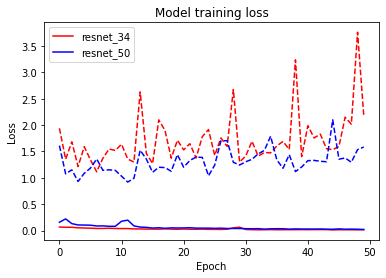

In [53]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_34.history['val_loss'], 'r--')
plt.plot(history_50.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

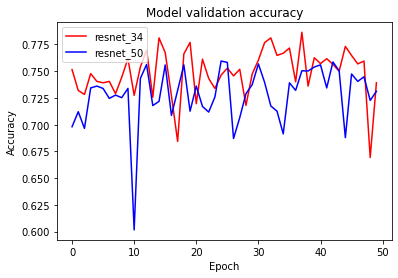

In [54]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

In [64]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152

In [56]:
model = ResNet50(include_top=True, weights=None, input_shape=(32, 32, 3), pooling=max, classes=2)

In [57]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [58]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 61/290 [=====>........................] - ETA: 16s - loss: 1.1278 - accuracy: 0.5067

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/290 [=====>........................] - ETA: 15s - loss: 1.1180 - accuracy: 0.5072

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 15s - loss: 1.1157 - accuracy: 0.5091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 14s - loss: 1.1034 - accuracy: 0.5091

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 14s - loss: 1.1015 - accuracy: 0.5091

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 6s - loss: 1.0619 - accuracy: 0.5133

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 5s - loss: 1.0621 - accuracy: 0.5126

212/290 [====================>.........] - ETA: 5s - loss: 1.0593 - accuracy: 0.5135

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 1.0477 - accuracy: 0.5168

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 1.0383 - accuracy: 0.5183

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 44s 97ms/step - loss: 1.0383 - accuracy: 0.5183 - val_loss: 0.7307 - val_accuracy: 0.5069


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/50
 62/290 [=====>........................] - ETA: 14s - loss: 0.9637 - accuracy: 0.5335

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 14s - loss: 0.9414 - accuracy: 0.5420

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 14s - loss: 0.9461 - accuracy: 0.5401

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 13s - loss: 0.9572 - accuracy: 0.5381

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 6s - loss: 0.9493 - accuracy: 0.5365

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 5s - loss: 0.9428 - accuracy: 0.5374

213/290 [=====================>........] - ETA: 5s - loss: 0.9413 - accuracy: 0.5376

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.9346 - accuracy: 0.5398

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.9278 - accuracy: 0.5417

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 93ms/step - loss: 0.9278 - accuracy: 0.5417 - val_loss: 0.7496 - val_accuracy: 0.5586
Epoch 3/50
 63/290 [=====>........................] - ETA: 16s - loss: 0.8372 - accuracy: 0.5640

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 16s - loss: 0.8388 - accuracy: 0.5625

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 15s - loss: 0.8400 - accuracy: 0.5623

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 14s - loss: 0.8407 - accuracy: 0.5629

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 6s - loss: 0.8223 - accuracy: 0.5768

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 5s - loss: 0.8184 - accuracy: 0.5775

214/290 [=====================>........] - ETA: 5s - loss: 0.8212 - accuracy: 0.5754

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.8193 - accuracy: 0.5761

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8084 - accuracy: 0.5816

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 93ms/step - loss: 0.8084 - accuracy: 0.5816 - val_loss: 1.0625 - val_accuracy: 0.5875


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/50
 64/290 [=====>........................] - ETA: 15s - loss: 0.7325 - accuracy: 0.6133

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 14s - loss: 0.7290 - accuracy: 0.6143

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 14s - loss: 0.7267 - accuracy: 0.6170

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 13s - loss: 0.7240 - accuracy: 0.6159

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 13s - loss: 0.7227 - accuracy: 0.6180

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 6s - loss: 0.7119 - accuracy: 0.6222

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 5s - loss: 0.7145 - accuracy: 0.6197

215/290 [=====================>........] - ETA: 5s - loss: 0.7137 - accuracy: 0.6206

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.7087 - accuracy: 0.6228

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.6280

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.7018 - accuracy: 0.6280 - val_loss: 1.2286 - val_accuracy: 0.5734


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/50
 65/290 [=====>........................] - ETA: 14s - loss: 0.6354 - accuracy: 0.6643

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 14s - loss: 0.6359 - accuracy: 0.6647

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 14s - loss: 0.6333 - accuracy: 0.6663

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 13s - loss: 0.6342 - accuracy: 0.6657

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 6s - loss: 0.6292 - accuracy: 0.6676

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 5s - loss: 0.6286 - accuracy: 0.6682

216/290 [=====================>........] - ETA: 4s - loss: 0.6290 - accuracy: 0.6676

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.6238 - accuracy: 0.6695

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6155 - accuracy: 0.6774

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 91ms/step - loss: 0.6155 - accuracy: 0.6774 - val_loss: 0.7262 - val_accuracy: 0.6207


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 6/50
 66/290 [=====>........................] - ETA: 14s - loss: 0.5534 - accuracy: 0.7244

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 14s - loss: 0.5520 - accuracy: 0.7270

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 13s - loss: 0.5553 - accuracy: 0.7262

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 12s - loss: 0.5553 - accuracy: 0.7268

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 12s - loss: 0.5591 - accuracy: 0.7241

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 6s - loss: 0.5441 - accuracy: 0.7359

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 5s - loss: 0.5390 - accuracy: 0.7402

217/290 [=====================>........] - ETA: 4s - loss: 0.5394 - accuracy: 0.7394

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 2s - loss: 0.5338 - accuracy: 0.7456

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.5285 - accuracy: 0.7496

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 90ms/step - loss: 0.5285 - accuracy: 0.7496 - val_loss: 0.8403 - val_accuracy: 0.6608


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 7/50
 67/290 [=====>........................] - ETA: 14s - loss: 0.4777 - accuracy: 0.7808

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 14s - loss: 0.4681 - accuracy: 0.7879

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 13s - loss: 0.4666 - accuracy: 0.7894

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 13s - loss: 0.4610 - accuracy: 0.7932

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 12s - loss: 0.4592 - accuracy: 0.7939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 6s - loss: 0.4326 - accuracy: 0.8086

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 5s - loss: 0.4312 - accuracy: 0.8088

217/290 [=====================>........] - ETA: 5s - loss: 0.4310 - accuracy: 0.8087

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 2s - loss: 0.4273 - accuracy: 0.8108

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8102

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 95ms/step - loss: 0.4279 - accuracy: 0.8102 - val_loss: 0.9883 - val_accuracy: 0.6602


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 8/50
 68/290 [======>.......................] - ETA: 14s - loss: 0.3310 - accuracy: 0.8670

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 13s - loss: 0.3275 - accuracy: 0.8678

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 13s - loss: 0.3326 - accuracy: 0.8654

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 12s - loss: 0.3310 - accuracy: 0.8666

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 5s - loss: 0.3238 - accuracy: 0.8676

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 4s - loss: 0.3207 - accuracy: 0.8702

219/290 [=====================>........] - ETA: 4s - loss: 0.3202 - accuracy: 0.8703

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 2s - loss: 0.3079 - accuracy: 0.8752

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.8755

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.3060 - accuracy: 0.8755 - val_loss: 1.0349 - val_accuracy: 0.6525


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 9/50
 69/290 [======>.......................] - ETA: 13s - loss: 0.2647 - accuracy: 0.8954

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 13s - loss: 0.2640 - accuracy: 0.8963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 13s - loss: 0.2628 - accuracy: 0.8962

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 12s - loss: 0.2590 - accuracy: 0.8966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 5s - loss: 0.2364 - accuracy: 0.9061

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 4s - loss: 0.2323 - accuracy: 0.9078

220/290 [=====================>........] - ETA: 4s - loss: 0.2323 - accuracy: 0.9079

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 2s - loss: 0.2285 - accuracy: 0.9099

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9106

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.2265 - accuracy: 0.9106 - val_loss: 1.2885 - val_accuracy: 0.6415


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 10/50
 70/290 [======>.......................] - ETA: 14s - loss: 0.1851 - accuracy: 0.9288

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 13s - loss: 0.1840 - accuracy: 0.9289

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 13s - loss: 0.1860 - accuracy: 0.9280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 12s - loss: 0.1789 - accuracy: 0.9309

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 5s - loss: 0.1790 - accuracy: 0.9304

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 4s - loss: 0.1796 - accuracy: 0.9298

221/290 [=====================>........] - ETA: 4s - loss: 0.1795 - accuracy: 0.9299

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 2s - loss: 0.1792 - accuracy: 0.9305

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9319

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.1755 - accuracy: 0.9319 - val_loss: 1.3955 - val_accuracy: 0.6773


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 11/50
 71/290 [======>.......................] - ETA: 14s - loss: 0.1562 - accuracy: 0.9390

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 13s - loss: 0.1524 - accuracy: 0.9407

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 13s - loss: 0.1512 - accuracy: 0.9420

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 12s - loss: 0.1572 - accuracy: 0.9383

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 5s - loss: 0.1532 - accuracy: 0.9411

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 4s - loss: 0.1522 - accuracy: 0.9417

222/290 [=====================>........] - ETA: 4s - loss: 0.1524 - accuracy: 0.9417

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 2s - loss: 0.1528 - accuracy: 0.9405

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9408

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.1526 - accuracy: 0.9408 - val_loss: 1.1666 - val_accuracy: 0.6827


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 12/50
 71/290 [======>.......................] - ETA: 16s - loss: 0.1424 - accuracy: 0.9454

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 15s - loss: 0.1398 - accuracy: 0.9461

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 15s - loss: 0.1384 - accuracy: 0.9468

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 13s - loss: 0.1416 - accuracy: 0.9454

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 13s - loss: 0.1422 - accuracy: 0.9447

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 6s - loss: 0.1332 - accuracy: 0.9479

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 4s - loss: 0.1336 - accuracy: 0.9480

223/290 [======================>.......] - ETA: 4s - loss: 0.1346 - accuracy: 0.9479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 2s - loss: 0.1325 - accuracy: 0.9485

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9497

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 93ms/step - loss: 0.1282 - accuracy: 0.9497 - val_loss: 2.1252 - val_accuracy: 0.6337


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 13/50
 73/290 [======>.......................] - ETA: 14s - loss: 0.1262 - accuracy: 0.9557

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 14s - loss: 0.1261 - accuracy: 0.9549

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 14s - loss: 0.1251 - accuracy: 0.9550

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 13s - loss: 0.1249 - accuracy: 0.9546

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 13s - loss: 0.1259 - accuracy: 0.9539

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 6s - loss: 0.1281 - accuracy: 0.9526

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 4s - loss: 0.1260 - accuracy: 0.9529

223/290 [======================>.......] - ETA: 4s - loss: 0.1256 - accuracy: 0.9531

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 2s - loss: 0.1221 - accuracy: 0.9544

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9545

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 97ms/step - loss: 0.1212 - accuracy: 0.9545 - val_loss: 1.3165 - val_accuracy: 0.6949


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 14/50
 74/290 [======>.......................] - ETA: 14s - loss: 0.1094 - accuracy: 0.9576

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 14s - loss: 0.1112 - accuracy: 0.9579

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 13s - loss: 0.1108 - accuracy: 0.9587

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 12s - loss: 0.1153 - accuracy: 0.9570

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 5s - loss: 0.1085 - accuracy: 0.9607

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 4s - loss: 0.1081 - accuracy: 0.9608

225/290 [======================>.......] - ETA: 4s - loss: 0.1068 - accuracy: 0.9613

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.1078 - accuracy: 0.9606

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9603

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.1077 - accuracy: 0.9603 - val_loss: 1.4476 - val_accuracy: 0.6992


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 15/50
 75/290 [======>.......................] - ETA: 13s - loss: 0.1023 - accuracy: 0.9622

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 13s - loss: 0.1042 - accuracy: 0.9615

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 13s - loss: 0.1028 - accuracy: 0.9618

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 12s - loss: 0.1025 - accuracy: 0.9610

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 5s - loss: 0.1074 - accuracy: 0.9607

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 4s - loss: 0.1074 - accuracy: 0.9605

226/290 [======================>.......] - ETA: 4s - loss: 0.1063 - accuracy: 0.9610

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.1038 - accuracy: 0.9621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9618

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.1049 - accuracy: 0.9618 - val_loss: 1.7242 - val_accuracy: 0.6667


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 16/50
 76/290 [======>.......................] - ETA: 13s - loss: 0.0954 - accuracy: 0.9657

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 13s - loss: 0.0949 - accuracy: 0.9657

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 13s - loss: 0.0957 - accuracy: 0.9647

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 12s - loss: 0.0943 - accuracy: 0.9644

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 5s - loss: 0.0933 - accuracy: 0.9658

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 4s - loss: 0.0935 - accuracy: 0.9660

227/290 [======================>.......] - ETA: 4s - loss: 0.0948 - accuracy: 0.9654

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.0908 - accuracy: 0.9672

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 91ms/step - loss: 0.0920 - accuracy: 0.9667 - val_loss: 1.5049 - val_accuracy: 0.6680


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 17/50
 77/290 [======>.......................] - ETA: 13s - loss: 0.0951 - accuracy: 0.9657

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 13s - loss: 0.0967 - accuracy: 0.9642

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 12s - loss: 0.0924 - accuracy: 0.9661

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 12s - loss: 0.0908 - accuracy: 0.9668

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 5s - loss: 0.0921 - accuracy: 0.9672

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 4s - loss: 0.0911 - accuracy: 0.9677

228/290 [======================>.......] - ETA: 3s - loss: 0.0906 - accuracy: 0.9679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0897 - accuracy: 0.9684

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9683

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0884 - accuracy: 0.9683 - val_loss: 1.6098 - val_accuracy: 0.6866


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 18/50
 78/290 [=======>......................] - ETA: 13s - loss: 0.0756 - accuracy: 0.9702

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 13s - loss: 0.0796 - accuracy: 0.9699

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 12s - loss: 0.0779 - accuracy: 0.9703

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 12s - loss: 0.0782 - accuracy: 0.9700

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 5s - loss: 0.0815 - accuracy: 0.9704

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 4s - loss: 0.0828 - accuracy: 0.9698

229/290 [======================>.......] - ETA: 3s - loss: 0.0818 - accuracy: 0.9702

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.0824 - accuracy: 0.9700

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9705

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0820 - accuracy: 0.9705 - val_loss: 1.8023 - val_accuracy: 0.6975


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 19/50
 79/290 [=======>......................] - ETA: 13s - loss: 0.0858 - accuracy: 0.9703

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 13s - loss: 0.0875 - accuracy: 0.9699

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 12s - loss: 0.0864 - accuracy: 0.9703

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 11s - loss: 0.0839 - accuracy: 0.9706

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 5s - loss: 0.0809 - accuracy: 0.9715

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 4s - loss: 0.0820 - accuracy: 0.9712

230/290 [======================>.......] - ETA: 3s - loss: 0.0820 - accuracy: 0.9712

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 1s - loss: 0.0806 - accuracy: 0.9717

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9724

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0796 - accuracy: 0.9724 - val_loss: 1.5120 - val_accuracy: 0.6653


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 20/50
 80/290 [=======>......................] - ETA: 13s - loss: 0.0782 - accuracy: 0.9721

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 13s - loss: 0.0759 - accuracy: 0.9727

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 12s - loss: 0.0746 - accuracy: 0.9730

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 11s - loss: 0.0762 - accuracy: 0.9731

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 5s - loss: 0.0770 - accuracy: 0.9723

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 4s - loss: 0.0786 - accuracy: 0.9719

231/290 [======================>.......] - ETA: 3s - loss: 0.0783 - accuracy: 0.9720

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


267/290 [==========================>...] - ETA: 1s - loss: 0.0764 - accuracy: 0.9729

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9731

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.0760 - accuracy: 0.9731 - val_loss: 2.1079 - val_accuracy: 0.6671


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 21/50
 81/290 [=======>......................] - ETA: 12s - loss: 0.0822 - accuracy: 0.9682

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 12s - loss: 0.0804 - accuracy: 0.9689

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 12s - loss: 0.0788 - accuracy: 0.9698

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 11s - loss: 0.0777 - accuracy: 0.9698

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 11s - loss: 0.0768 - accuracy: 0.9702

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 5s - loss: 0.0721 - accuracy: 0.9728

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 4s - loss: 0.0730 - accuracy: 0.9725

232/290 [=======================>......] - ETA: 3s - loss: 0.0729 - accuracy: 0.9725

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.0714 - accuracy: 0.9732

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9739

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 90ms/step - loss: 0.0699 - accuracy: 0.9739 - val_loss: 1.8835 - val_accuracy: 0.6910


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 22/50
 82/290 [=======>......................] - ETA: 13s - loss: 0.0600 - accuracy: 0.9806

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 12s - loss: 0.0605 - accuracy: 0.9796

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 12s - loss: 0.0606 - accuracy: 0.9796

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 11s - loss: 0.0624 - accuracy: 0.9787

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.0623 - accuracy: 0.9786

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 4s - loss: 0.0638 - accuracy: 0.9788

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 0.0635 - accuracy: 0.9792

233/290 [=======================>......] - ETA: 3s - loss: 0.0639 - accuracy: 0.9793

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/290 [==========================>...] - ETA: 1s - loss: 0.0641 - accuracy: 0.9793

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9791

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 88ms/step - loss: 0.0643 - accuracy: 0.9791 - val_loss: 1.6949 - val_accuracy: 0.7029


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 23/50
 83/290 [=======>......................] - ETA: 13s - loss: 0.0656 - accuracy: 0.9776

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 13s - loss: 0.0652 - accuracy: 0.9781

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 12s - loss: 0.0655 - accuracy: 0.9780

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 11s - loss: 0.0629 - accuracy: 0.9784

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 11s - loss: 0.0627 - accuracy: 0.9785

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 4s - loss: 0.0618 - accuracy: 0.9780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.0613 - accuracy: 0.9782

234/290 [=======================>......] - ETA: 3s - loss: 0.0610 - accuracy: 0.9783

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


270/290 [==========================>...] - ETA: 1s - loss: 0.0599 - accuracy: 0.9786

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9784

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 90ms/step - loss: 0.0615 - accuracy: 0.9784 - val_loss: 2.3825 - val_accuracy: 0.6610


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 24/50
 83/290 [=======>......................] - ETA: 15s - loss: 0.0702 - accuracy: 0.9761

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 14s - loss: 0.0685 - accuracy: 0.9762

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 14s - loss: 0.0688 - accuracy: 0.9758

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 13s - loss: 0.0676 - accuracy: 0.9762

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 13s - loss: 0.0675 - accuracy: 0.9763

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 5s - loss: 0.0650 - accuracy: 0.9768

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 4s - loss: 0.0637 - accuracy: 0.9773

235/290 [=======================>......] - ETA: 3s - loss: 0.0641 - accuracy: 0.9772

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 1s - loss: 0.0641 - accuracy: 0.9773

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9774

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 95ms/step - loss: 0.0640 - accuracy: 0.9774 - val_loss: 1.7428 - val_accuracy: 0.6813


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 25/50
 85/290 [=======>......................] - ETA: 13s - loss: 0.0607 - accuracy: 0.9783

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 13s - loss: 0.0580 - accuracy: 0.9796

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 13s - loss: 0.0578 - accuracy: 0.9797

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 12s - loss: 0.0564 - accuracy: 0.9798

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 12s - loss: 0.0564 - accuracy: 0.9797

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 5s - loss: 0.0569 - accuracy: 0.9795

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 4s - loss: 0.0569 - accuracy: 0.9795

235/290 [=======================>......] - ETA: 3s - loss: 0.0562 - accuracy: 0.9797

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/290 [===========================>..] - ETA: 1s - loss: 0.0582 - accuracy: 0.9787

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9794

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 29s 101ms/step - loss: 0.0575 - accuracy: 0.9794 - val_loss: 1.9562 - val_accuracy: 0.6758


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 26/50
 86/290 [=======>......................] - ETA: 13s - loss: 0.0457 - accuracy: 0.9818

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 12s - loss: 0.0470 - accuracy: 0.9814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 12s - loss: 0.0494 - accuracy: 0.9813

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 11s - loss: 0.0501 - accuracy: 0.9812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 4s - loss: 0.0561 - accuracy: 0.9798

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 0.0584 - accuracy: 0.9791

237/290 [=======================>......] - ETA: 3s - loss: 0.0579 - accuracy: 0.9795

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


273/290 [===========================>..] - ETA: 1s - loss: 0.0580 - accuracy: 0.9796

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9797

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0578 - accuracy: 0.9797 - val_loss: 1.5413 - val_accuracy: 0.6762


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 27/50
 87/290 [========>.....................] - ETA: 12s - loss: 0.0444 - accuracy: 0.9846

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 12s - loss: 0.0461 - accuracy: 0.9844

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 12s - loss: 0.0453 - accuracy: 0.9848

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 11s - loss: 0.0464 - accuracy: 0.9845

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 4s - loss: 0.0518 - accuracy: 0.9824

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 3s - loss: 0.0517 - accuracy: 0.9822

238/290 [=======================>......] - ETA: 3s - loss: 0.0518 - accuracy: 0.9822

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 1s - loss: 0.0534 - accuracy: 0.9814

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9815

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0531 - accuracy: 0.9815 - val_loss: 1.8507 - val_accuracy: 0.7023


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 28/50
 88/290 [========>.....................] - ETA: 12s - loss: 0.0585 - accuracy: 0.9804

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 12s - loss: 0.0567 - accuracy: 0.9810

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 12s - loss: 0.0571 - accuracy: 0.9809

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 11s - loss: 0.0556 - accuracy: 0.9817

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 4s - loss: 0.0525 - accuracy: 0.9825

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 3s - loss: 0.0521 - accuracy: 0.9827

239/290 [=======================>......] - ETA: 3s - loss: 0.0520 - accuracy: 0.9827

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


275/290 [===========================>..] - ETA: 0s - loss: 0.0502 - accuracy: 0.9833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9828

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0509 - accuracy: 0.9828 - val_loss: 1.5587 - val_accuracy: 0.6997


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 29/50
 89/290 [========>.....................] - ETA: 12s - loss: 0.0523 - accuracy: 0.9807

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 12s - loss: 0.0538 - accuracy: 0.9803

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 11s - loss: 0.0548 - accuracy: 0.9800

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 11s - loss: 0.0537 - accuracy: 0.9807

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 11s - loss: 0.0540 - accuracy: 0.9806

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 4s - loss: 0.0507 - accuracy: 0.9818

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 3s - loss: 0.0510 - accuracy: 0.9818

240/290 [=======================>......] - ETA: 3s - loss: 0.0511 - accuracy: 0.9816

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 0.0495 - accuracy: 0.9819

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9822

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0491 - accuracy: 0.9822 - val_loss: 1.7492 - val_accuracy: 0.7059


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 30/50
 90/290 [========>.....................] - ETA: 12s - loss: 0.0508 - accuracy: 0.9812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 12s - loss: 0.0502 - accuracy: 0.9816

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 12s - loss: 0.0498 - accuracy: 0.9818

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 11s - loss: 0.0481 - accuracy: 0.9821

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 4s - loss: 0.0540 - accuracy: 0.9815

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 3s - loss: 0.0545 - accuracy: 0.9817

241/290 [=======================>......] - ETA: 3s - loss: 0.0538 - accuracy: 0.9820

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 0.0531 - accuracy: 0.9821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9824

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.0522 - accuracy: 0.9824 - val_loss: 1.9405 - val_accuracy: 0.6897


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 31/50
 91/290 [========>.....................] - ETA: 12s - loss: 0.0442 - accuracy: 0.9828

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 12s - loss: 0.0442 - accuracy: 0.9828

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 12s - loss: 0.0446 - accuracy: 0.9829

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 11s - loss: 0.0447 - accuracy: 0.9832

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9835

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 4s - loss: 0.0463 - accuracy: 0.9834

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 3s - loss: 0.0478 - accuracy: 0.9829

242/290 [========================>.....] - ETA: 3s - loss: 0.0480 - accuracy: 0.9826

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/290 [===========================>..] - ETA: 0s - loss: 0.0492 - accuracy: 0.9823

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9823

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0492 - accuracy: 0.9823 - val_loss: 1.6164 - val_accuracy: 0.7070


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 32/50
 92/290 [========>.....................] - ETA: 12s - loss: 0.0440 - accuracy: 0.9844

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 12s - loss: 0.0459 - accuracy: 0.9837

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 12s - loss: 0.0471 - accuracy: 0.9836

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 11s - loss: 0.0459 - accuracy: 0.9838

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 10s - loss: 0.0455 - accuracy: 0.9837

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 4s - loss: 0.0415 - accuracy: 0.9855

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


238/290 [=======================>......] - ETA: 3s - loss: 0.0420 - accuracy: 0.9852

243/290 [========================>.....] - ETA: 3s - loss: 0.0426 - accuracy: 0.9851

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/290 [===========================>..] - ETA: 0s - loss: 0.0417 - accuracy: 0.9855

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9855

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 90ms/step - loss: 0.0421 - accuracy: 0.9855 - val_loss: 1.9259 - val_accuracy: 0.7029


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 33/50
 93/290 [========>.....................] - ETA: 12s - loss: 0.0460 - accuracy: 0.9820

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 12s - loss: 0.0467 - accuracy: 0.9820

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 12s - loss: 0.0456 - accuracy: 0.9826

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


118/290 [===========>..................] - ETA: 11s - loss: 0.0449 - accuracy: 0.9826

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 4s - loss: 0.0442 - accuracy: 0.9846

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 3s - loss: 0.0448 - accuracy: 0.9845

244/290 [========================>.....] - ETA: 2s - loss: 0.0445 - accuracy: 0.9846

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/290 [===========================>..] - ETA: 0s - loss: 0.0440 - accuracy: 0.9848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9850

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 90ms/step - loss: 0.0434 - accuracy: 0.9850 - val_loss: 1.9750 - val_accuracy: 0.6804


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 34/50
 94/290 [========>.....................] - ETA: 12s - loss: 0.0484 - accuracy: 0.9842

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 12s - loss: 0.0476 - accuracy: 0.9844

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9847

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 11s - loss: 0.0475 - accuracy: 0.9840

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 4s - loss: 0.0477 - accuracy: 0.9836

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 3s - loss: 0.0471 - accuracy: 0.9840

245/290 [========================>.....] - ETA: 2s - loss: 0.0470 - accuracy: 0.9840

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/290 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9841

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9842

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0472 - accuracy: 0.9842 - val_loss: 2.2080 - val_accuracy: 0.6562
Epoch 35/50
 95/290 [========>.....................] - ETA: 13s - loss: 0.0361 - accuracy: 0.9868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 13s - loss: 0.0353 - accuracy: 0.9871

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 12s - loss: 0.0357 - accuracy: 0.9873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 11s - loss: 0.0352 - accuracy: 0.9876

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 4s - loss: 0.0404 - accuracy: 0.9862

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 3s - loss: 0.0412 - accuracy: 0.9859

246/290 [========================>.....] - ETA: 2s - loss: 0.0409 - accuracy: 0.9860

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/290 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.9862

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9863

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0402 - accuracy: 0.9863 - val_loss: 1.7753 - val_accuracy: 0.6963


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 36/50
 96/290 [========>.....................] - ETA: 11s - loss: 0.0428 - accuracy: 0.9862

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 11s - loss: 0.0427 - accuracy: 0.9861

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 11s - loss: 0.0418 - accuracy: 0.9863

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 10s - loss: 0.0418 - accuracy: 0.9864

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 3s - loss: 0.0378 - accuracy: 0.9870

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


242/290 [========================>.....] - ETA: 2s - loss: 0.0391 - accuracy: 0.9865

247/290 [========================>.....] - ETA: 2s - loss: 0.0388 - accuracy: 0.9866

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/290 [============================>.] - ETA: 0s - loss: 0.0393 - accuracy: 0.9864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9862

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0396 - accuracy: 0.9862 - val_loss: 1.8678 - val_accuracy: 0.6941


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 37/50
 97/290 [=========>....................] - ETA: 12s - loss: 0.0379 - accuracy: 0.9879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 11s - loss: 0.0411 - accuracy: 0.9871

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 11s - loss: 0.0401 - accuracy: 0.9874

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 10s - loss: 0.0424 - accuracy: 0.9864

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 3s - loss: 0.0394 - accuracy: 0.9864

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


243/290 [========================>.....] - ETA: 2s - loss: 0.0384 - accuracy: 0.9869

248/290 [========================>.....] - ETA: 2s - loss: 0.0389 - accuracy: 0.9865

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/290 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9865

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9867

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.0383 - accuracy: 0.9867 - val_loss: 2.4892 - val_accuracy: 0.6631


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 38/50
 98/290 [=========>....................] - ETA: 11s - loss: 0.0424 - accuracy: 0.9853

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 11s - loss: 0.0410 - accuracy: 0.9859

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.0426 - accuracy: 0.9848

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


123/290 [===========>..................] - ETA: 10s - loss: 0.0408 - accuracy: 0.9853

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 0.0391 - accuracy: 0.9857

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


244/290 [========================>.....] - ETA: 2s - loss: 0.0384 - accuracy: 0.9860

249/290 [========================>.....] - ETA: 2s - loss: 0.0389 - accuracy: 0.9859

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/290 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9864

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0380 - accuracy: 0.9864 - val_loss: 1.6110 - val_accuracy: 0.6992


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 39/50
 99/290 [=========>....................] - ETA: 11s - loss: 0.0430 - accuracy: 0.9850

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 11s - loss: 0.0425 - accuracy: 0.9855

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 10s - loss: 0.0439 - accuracy: 0.9848

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


124/290 [===========>..................] - ETA: 10s - loss: 0.0430 - accuracy: 0.9850

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.0408 - accuracy: 0.9856

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


245/290 [========================>.....] - ETA: 2s - loss: 0.0399 - accuracy: 0.9860

250/290 [========================>.....] - ETA: 2s - loss: 0.0400 - accuracy: 0.9859

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


286/290 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9858

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9859

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.0408 - accuracy: 0.9859 - val_loss: 1.6815 - val_accuracy: 0.6985
Epoch 40/50
100/290 [=========>....................] - ETA: 11s - loss: 0.0363 - accuracy: 0.9886

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 11s - loss: 0.0358 - accuracy: 0.9886

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 11s - loss: 0.0347 - accuracy: 0.9891

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/290 [===========>..................] - ETA: 10s - loss: 0.0323 - accuracy: 0.9896

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 3s - loss: 0.0351 - accuracy: 0.9882

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 0.0346 - accuracy: 0.9883

251/290 [========================>.....] - ETA: 2s - loss: 0.0352 - accuracy: 0.9880

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


287/290 [============================>.] - ETA: 0s - loss: 0.0359 - accuracy: 0.9877

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9877

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0360 - accuracy: 0.9877 - val_loss: 2.1734 - val_accuracy: 0.6731


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 41/50
101/290 [=========>....................] - ETA: 11s - loss: 0.0381 - accuracy: 0.9868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 11s - loss: 0.0368 - accuracy: 0.9873

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 10s - loss: 0.0364 - accuracy: 0.9873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


126/290 [============>.................] - ETA: 10s - loss: 0.0344 - accuracy: 0.9880

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


231/290 [======================>.......] - ETA: 3s - loss: 0.0381 - accuracy: 0.9871

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


247/290 [========================>.....] - ETA: 2s - loss: 0.0379 - accuracy: 0.9870

252/290 [=========================>....] - ETA: 2s - loss: 0.0378 - accuracy: 0.9870

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


288/290 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9871

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9870

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0384 - accuracy: 0.9870 - val_loss: 1.8566 - val_accuracy: 0.6845


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 42/50
102/290 [=========>....................] - ETA: 11s - loss: 0.0354 - accuracy: 0.9880

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 11s - loss: 0.0347 - accuracy: 0.9881

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 10s - loss: 0.0345 - accuracy: 0.9882

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


127/290 [============>.................] - ETA: 10s - loss: 0.0345 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 0.0348 - accuracy: 0.9879

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 0.0359 - accuracy: 0.9872

253/290 [=========================>....] - ETA: 2s - loss: 0.0360 - accuracy: 0.9871

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.9874

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9875

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0357 - accuracy: 0.9875 - val_loss: 1.6281 - val_accuracy: 0.6994


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 43/50
103/290 [=========>....................] - ETA: 11s - loss: 0.0353 - accuracy: 0.9879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 11s - loss: 0.0364 - accuracy: 0.9874

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 10s - loss: 0.0367 - accuracy: 0.9876

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


128/290 [============>.................] - ETA: 10s - loss: 0.0359 - accuracy: 0.9882

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 3s - loss: 0.0376 - accuracy: 0.9876

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.0362 - accuracy: 0.9882

254/290 [=========================>....] - ETA: 2s - loss: 0.0358 - accuracy: 0.9884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9888

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 25s 86ms/step - loss: 0.0345 - accuracy: 0.9888 - val_loss: 2.0111 - val_accuracy: 0.6981


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 44/50
104/290 [=========>....................] - ETA: 11s - loss: 0.0356 - accuracy: 0.9881

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.0348 - accuracy: 0.9884

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 11s - loss: 0.0341 - accuracy: 0.9884

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


129/290 [============>.................] - ETA: 10s - loss: 0.0342 - accuracy: 0.9884

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 0.0312 - accuracy: 0.9893

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 0.0311 - accuracy: 0.9893

253/290 [=========================>....] - ETA: 2s - loss: 0.0307 - accuracy: 0.9894

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9893

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 26s 90ms/step - loss: 0.0316 - accuracy: 0.9893 - val_loss: 1.9510 - val_accuracy: 0.7122


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 45/50
104/290 [=========>....................] - ETA: 11s - loss: 0.0379 - accuracy: 0.9875

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.0383 - accuracy: 0.9876

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 10s - loss: 0.0371 - accuracy: 0.9880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


129/290 [============>.................] - ETA: 9s - loss: 0.0378 - accuracy: 0.9876

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 3s - loss: 0.0355 - accuracy: 0.9881

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.0364 - accuracy: 0.9878

256/290 [=========================>....] - ETA: 2s - loss: 0.0364 - accuracy: 0.9879

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9887

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 25s 86ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 1.9672 - val_accuracy: 0.7162


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 46/50
106/290 [=========>....................] - ETA: 11s - loss: 0.0297 - accuracy: 0.9885

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 10s - loss: 0.0316 - accuracy: 0.9883

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


118/290 [===========>..................] - ETA: 10s - loss: 0.0313 - accuracy: 0.9885

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


131/290 [============>.................] - ETA: 9s - loss: 0.0332 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 3s - loss: 0.0324 - accuracy: 0.9885

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.0330 - accuracy: 0.9881

257/290 [=========================>....] - ETA: 2s - loss: 0.0326 - accuracy: 0.9883

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0327 - accuracy: 0.9883 - val_loss: 1.8345 - val_accuracy: 0.7011


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Epoch 47/50
107/290 [==========>...................] - ETA: 11s - loss: 0.0337 - accuracy: 0.9863

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 10s - loss: 0.0341 - accuracy: 0.9863

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 10s - loss: 0.0334 - accuracy: 0.9867

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


132/290 [============>.................] - ETA: 9s - loss: 0.0330 - accuracy: 0.9870

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 3s - loss: 0.0333 - accuracy: 0.9875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 2s - loss: 0.0331 - accuracy: 0.9876

258/290 [=========================>....] - ETA: 1s - loss: 0.0329 - accuracy: 0.9877

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9877

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0330 - accuracy: 0.9877 - val_loss: 2.3736 - val_accuracy: 0.6773


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 48/50
  4/290 [..............................] - ETA: 19s - loss: 0.0241 - accuracy: 0.9883

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 11s - loss: 0.0385 - accuracy: 0.9884

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 11s - loss: 0.0372 - accuracy: 0.9886

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 10s - loss: 0.0384 - accuracy: 0.9880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


133/290 [============>.................] - ETA: 9s - loss: 0.0369 - accuracy: 0.9882

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


238/290 [=======================>......] - ETA: 3s - loss: 0.0349 - accuracy: 0.9888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 2s - loss: 0.0341 - accuracy: 0.9889

259/290 [=========================>....] - ETA: 1s - loss: 0.0337 - accuracy: 0.9890

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9890

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0329 - accuracy: 0.9890 - val_loss: 1.9930 - val_accuracy: 0.7183


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 49/50
  5/290 [..............................] - ETA: 18s - loss: 0.0482 - accuracy: 0.9875

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 11s - loss: 0.0396 - accuracy: 0.9891

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 10s - loss: 0.0395 - accuracy: 0.9890

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 10s - loss: 0.0393 - accuracy: 0.9888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


134/290 [============>.................] - ETA: 9s - loss: 0.0393 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


137/290 [=============>................] - ETA: 9s - loss: 0.0387 - accuracy: 0.9885

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 3s - loss: 0.0358 - accuracy: 0.9886

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 2s - loss: 0.0355 - accuracy: 0.9887

260/290 [=========================>....] - ETA: 1s - loss: 0.0355 - accuracy: 0.9886

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9890

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0346 - accuracy: 0.9890 - val_loss: 2.2654 - val_accuracy: 0.6892


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 50/50
  6/290 [..............................] - ETA: 19s - loss: 0.0312 - accuracy: 0.9922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.0280 - accuracy: 0.9896

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 10s - loss: 0.0278 - accuracy: 0.9896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 10s - loss: 0.0272 - accuracy: 0.9899

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


135/290 [============>.................] - ETA: 9s - loss: 0.0281 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 3s - loss: 0.0297 - accuracy: 0.9904

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 2s - loss: 0.0301 - accuracy: 0.9903

261/290 [==========================>...] - ETA: 1s - loss: 0.0297 - accuracy: 0.9904

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0290 - accuracy: 0.9907 - val_loss: 2.1163 - val_accuracy: 0.6840


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


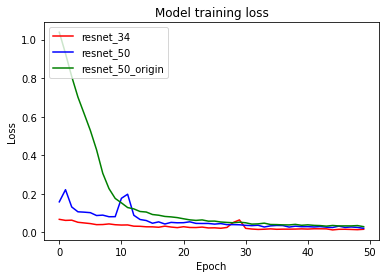

In [59]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'resnet_50_origin'], loc='upper left')
plt.show()

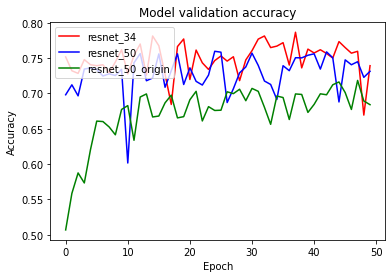

In [60]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'resnet_50_origin'], loc='upper left')
plt.show()

In [65]:
model_152 = ResNet152(include_top=True, weights=None, input_shape=(32, 32, 3), pooling=max, classes=2)

In [66]:
learning_rate = 0.0001
model_152.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history_152 = model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 61/290 [=====>........................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9900

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/290 [=====>........................] - ETA: 13s - loss: 0.0273 - accuracy: 0.9904

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 13s - loss: 0.0276 - accuracy: 0.9906

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 12s - loss: 0.0279 - accuracy: 0.9909

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 6s - loss: 0.0299 - accuracy: 0.9896

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 5s - loss: 0.0301 - accuracy: 0.9895

212/290 [====================>.........] - ETA: 4s - loss: 0.0297 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 0.0301 - accuracy: 0.9897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 30s 85ms/step - loss: 0.0305 - accuracy: 0.9896 - val_loss: 1.9071 - val_accuracy: 0.6953


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/50
 62/290 [=====>........................] - ETA: 14s - loss: 0.0277 - accuracy: 0.9899

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 13s - loss: 0.0286 - accuracy: 0.9897

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 13s - loss: 0.0279 - accuracy: 0.9903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 12s - loss: 0.0291 - accuracy: 0.9907

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 5s - loss: 0.0309 - accuracy: 0.9899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 5s - loss: 0.0292 - accuracy: 0.9904

213/290 [=====================>........] - ETA: 4s - loss: 0.0288 - accuracy: 0.9906

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.0300 - accuracy: 0.9903

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9906

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.0283 - accuracy: 0.9906 - val_loss: 1.9365 - val_accuracy: 0.7044


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/50
 63/290 [=====>........................] - ETA: 14s - loss: 0.0249 - accuracy: 0.9903

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 13s - loss: 0.0237 - accuracy: 0.9907

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 13s - loss: 0.0252 - accuracy: 0.9900

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9901

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 5s - loss: 0.0283 - accuracy: 0.9900

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.0274 - accuracy: 0.9903

214/290 [=====================>........] - ETA: 4s - loss: 0.0275 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.0295 - accuracy: 0.9900

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9892

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0312 - accuracy: 0.9892 - val_loss: 1.7350 - val_accuracy: 0.7047


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/50
 64/290 [=====>........................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 13s - loss: 0.0235 - accuracy: 0.9913

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 13s - loss: 0.0254 - accuracy: 0.9905

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 12s - loss: 0.0276 - accuracy: 0.9903

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 6s - loss: 0.0300 - accuracy: 0.9898

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 5s - loss: 0.0295 - accuracy: 0.9899

215/290 [=====================>........] - ETA: 4s - loss: 0.0290 - accuracy: 0.9900

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.0288 - accuracy: 0.9898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0274 - accuracy: 0.9902 - val_loss: 1.7760 - val_accuracy: 0.6997


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/50
 65/290 [=====>........................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9935

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9934

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 13s - loss: 0.0182 - accuracy: 0.9935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 12s - loss: 0.0201 - accuracy: 0.9927

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 6s - loss: 0.0252 - accuracy: 0.9907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 5s - loss: 0.0255 - accuracy: 0.9907

216/290 [=====================>........] - ETA: 4s - loss: 0.0250 - accuracy: 0.9910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.0261 - accuracy: 0.9911

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9906

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0273 - accuracy: 0.9906 - val_loss: 2.0911 - val_accuracy: 0.6923


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 6/50
 66/290 [=====>........................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 13s - loss: 0.0293 - accuracy: 0.9881

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 12s - loss: 0.0278 - accuracy: 0.9888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 12s - loss: 0.0273 - accuracy: 0.9892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 5s - loss: 0.0262 - accuracy: 0.9899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 4s - loss: 0.0260 - accuracy: 0.9899

217/290 [=====================>........] - ETA: 4s - loss: 0.0257 - accuracy: 0.9899

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 2s - loss: 0.0265 - accuracy: 0.9894

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9894

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.0267 - accuracy: 0.9894 - val_loss: 1.9451 - val_accuracy: 0.7034


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 7/50
 67/290 [=====>........................] - ETA: 13s - loss: 0.0260 - accuracy: 0.9914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9919

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 12s - loss: 0.0238 - accuracy: 0.9921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 12s - loss: 0.0227 - accuracy: 0.9920

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 5s - loss: 0.0261 - accuracy: 0.9915

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 4s - loss: 0.0260 - accuracy: 0.9917

218/290 [=====================>........] - ETA: 4s - loss: 0.0258 - accuracy: 0.9917

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 2s - loss: 0.0257 - accuracy: 0.9916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0259 - accuracy: 0.9913 - val_loss: 1.9139 - val_accuracy: 0.7246


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 8/50
 68/290 [======>.......................] - ETA: 13s - loss: 0.0218 - accuracy: 0.9938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 13s - loss: 0.0254 - accuracy: 0.9928

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 12s - loss: 0.0265 - accuracy: 0.9922

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 12s - loss: 0.0276 - accuracy: 0.9919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 5s - loss: 0.0268 - accuracy: 0.9918

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 4s - loss: 0.0276 - accuracy: 0.9912

219/290 [=====================>........] - ETA: 4s - loss: 0.0272 - accuracy: 0.9913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 2s - loss: 0.0270 - accuracy: 0.9917

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9914

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 1.9861 - val_accuracy: 0.7082


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 9/50
 69/290 [======>.......................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9903

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 13s - loss: 0.0302 - accuracy: 0.9900

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 12s - loss: 0.0303 - accuracy: 0.9902

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 12s - loss: 0.0289 - accuracy: 0.9907

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 5s - loss: 0.0286 - accuracy: 0.9914

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 4s - loss: 0.0290 - accuracy: 0.9913

220/290 [=====================>........] - ETA: 4s - loss: 0.0291 - accuracy: 0.9912

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9915

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0283 - accuracy: 0.9915 - val_loss: 2.2990 - val_accuracy: 0.6879


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 10/50
 70/290 [======>.......................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 14s - loss: 0.0282 - accuracy: 0.9922

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 12s - loss: 0.0273 - accuracy: 0.9927

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 6s - loss: 0.0289 - accuracy: 0.9908

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 4s - loss: 0.0284 - accuracy: 0.9908

221/290 [=====================>........] - ETA: 4s - loss: 0.0281 - accuracy: 0.9909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 2s - loss: 0.0271 - accuracy: 0.9911

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 2.3912 - val_accuracy: 0.6844


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 11/50
 71/290 [======>.......................] - ETA: 13s - loss: 0.0259 - accuracy: 0.9901

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 13s - loss: 0.0287 - accuracy: 0.9892

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 12s - loss: 0.0286 - accuracy: 0.9895

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 12s - loss: 0.0261 - accuracy: 0.9904

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 5s - loss: 0.0255 - accuracy: 0.9907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 4s - loss: 0.0261 - accuracy: 0.9905

222/290 [=====================>........] - ETA: 4s - loss: 0.0270 - accuracy: 0.9903

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.0254 - accuracy: 0.9912

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9914

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.0246 - accuracy: 0.9914 - val_loss: 2.1444 - val_accuracy: 0.7153


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 12/50
 72/290 [======>.......................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 13s - loss: 0.0234 - accuracy: 0.9924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 12s - loss: 0.0243 - accuracy: 0.9926

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 12s - loss: 0.0226 - accuracy: 0.9928

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 5s - loss: 0.0240 - accuracy: 0.9920

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 4s - loss: 0.0246 - accuracy: 0.9918

223/290 [======================>.......] - ETA: 4s - loss: 0.0244 - accuracy: 0.9918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.0234 - accuracy: 0.9921

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9925

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.0222 - accuracy: 0.9925 - val_loss: 2.3055 - val_accuracy: 0.7140
Epoch 13/50
 73/290 [======>.......................] - ETA: 13s - loss: 0.0286 - accuracy: 0.9921

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 12s - loss: 0.0282 - accuracy: 0.9919

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 12s - loss: 0.0269 - accuracy: 0.9921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 11s - loss: 0.0260 - accuracy: 0.9922

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 5s - loss: 0.0267 - accuracy: 0.9911

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 4s - loss: 0.0262 - accuracy: 0.9912

224/290 [======================>.......] - ETA: 4s - loss: 0.0274 - accuracy: 0.9909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.0261 - accuracy: 0.9912

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9915

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 1.9358 - val_accuracy: 0.6973


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 14/50
 74/290 [======>.......................] - ETA: 13s - loss: 0.0241 - accuracy: 0.9920

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 12s - loss: 0.0228 - accuracy: 0.9924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 12s - loss: 0.0214 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 11s - loss: 0.0228 - accuracy: 0.9924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 5s - loss: 0.0251 - accuracy: 0.9919

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 4s - loss: 0.0253 - accuracy: 0.9918

225/290 [======================>.......] - ETA: 4s - loss: 0.0248 - accuracy: 0.9920

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.0254 - accuracy: 0.9919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9915

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0255 - accuracy: 0.9915 - val_loss: 2.1355 - val_accuracy: 0.7190
Epoch 15/50
 75/290 [======>.......................] - ETA: 17s - loss: 0.0234 - accuracy: 0.9919

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 16s - loss: 0.0222 - accuracy: 0.9923

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 15s - loss: 0.0230 - accuracy: 0.9923

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 14s - loss: 0.0230 - accuracy: 0.9923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9926

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 6s - loss: 0.0232 - accuracy: 0.9919

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9921

226/290 [======================>.......] - ETA: 4s - loss: 0.0223 - accuracy: 0.9921

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.0231 - accuracy: 0.9922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9924

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 97ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 2.0113 - val_accuracy: 0.6967


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 16/50
 76/290 [======>.......................] - ETA: 14s - loss: 0.0229 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 14s - loss: 0.0236 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 13s - loss: 0.0234 - accuracy: 0.9933

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9932

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 12s - loss: 0.0227 - accuracy: 0.9932

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 5s - loss: 0.0242 - accuracy: 0.9921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 4s - loss: 0.0255 - accuracy: 0.9915

227/290 [======================>.......] - ETA: 4s - loss: 0.0254 - accuracy: 0.9916

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.0244 - accuracy: 0.9917

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9919

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 94ms/step - loss: 0.0243 - accuracy: 0.9919 - val_loss: 1.7850 - val_accuracy: 0.7235


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 17/50
 77/290 [======>.......................] - ETA: 14s - loss: 0.0255 - accuracy: 0.9915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 14s - loss: 0.0242 - accuracy: 0.9917

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 12s - loss: 0.0233 - accuracy: 0.9920

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9920

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 5s - loss: 0.0241 - accuracy: 0.9917

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 4s - loss: 0.0240 - accuracy: 0.9917

228/290 [======================>.......] - ETA: 4s - loss: 0.0235 - accuracy: 0.9919

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0236 - accuracy: 0.9919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9920

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 30s 102ms/step - loss: 0.0231 - accuracy: 0.9920 - val_loss: 1.9710 - val_accuracy: 0.7144


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 18/50
 78/290 [=======>......................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 14s - loss: 0.0203 - accuracy: 0.9911

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 14s - loss: 0.0196 - accuracy: 0.9914

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 13s - loss: 0.0240 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 12s - loss: 0.0254 - accuracy: 0.9891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 5s - loss: 0.0230 - accuracy: 0.9911

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 4s - loss: 0.0237 - accuracy: 0.9911

229/290 [======================>.......] - ETA: 4s - loss: 0.0242 - accuracy: 0.9910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0238 - accuracy: 0.9909

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9909

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 96ms/step - loss: 0.0244 - accuracy: 0.9909 - val_loss: 1.8927 - val_accuracy: 0.7240


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 19/50
 78/290 [=======>......................] - ETA: 14s - loss: 0.0221 - accuracy: 0.9926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 14s - loss: 0.0210 - accuracy: 0.9931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 14s - loss: 0.0196 - accuracy: 0.9936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 13s - loss: 0.0200 - accuracy: 0.9935

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 13s - loss: 0.0201 - accuracy: 0.9934

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9945

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 4s - loss: 0.0172 - accuracy: 0.9946

230/290 [======================>.......] - ETA: 4s - loss: 0.0175 - accuracy: 0.9946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.0177 - accuracy: 0.9946

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 29s 99ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 2.5757 - val_accuracy: 0.7034


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 20/50
 80/290 [=======>......................] - ETA: 14s - loss: 0.0221 - accuracy: 0.9929

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 12s - loss: 0.0202 - accuracy: 0.9932

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 5s - loss: 0.0229 - accuracy: 0.9928

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 4s - loss: 0.0221 - accuracy: 0.9930

231/290 [======================>.......] - ETA: 3s - loss: 0.0230 - accuracy: 0.9927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


267/290 [==========================>...] - ETA: 1s - loss: 0.0237 - accuracy: 0.9922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9922

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 94ms/step - loss: 0.0235 - accuracy: 0.9922 - val_loss: 2.1553 - val_accuracy: 0.6896


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 21/50
 81/290 [=======>......................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9954

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 13s - loss: 0.0160 - accuracy: 0.9948

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 12s - loss: 0.0180 - accuracy: 0.9937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 5s - loss: 0.0186 - accuracy: 0.9939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 4s - loss: 0.0202 - accuracy: 0.9937

232/290 [=======================>......] - ETA: 3s - loss: 0.0202 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.0204 - accuracy: 0.9938

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 93ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 1.8004 - val_accuracy: 0.7144


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 22/50
 82/290 [=======>......................] - ETA: 13s - loss: 0.0275 - accuracy: 0.9899

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 13s - loss: 0.0262 - accuracy: 0.9906

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 13s - loss: 0.0248 - accuracy: 0.9912

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 12s - loss: 0.0251 - accuracy: 0.9915

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 12s - loss: 0.0251 - accuracy: 0.9916

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 5s - loss: 0.0236 - accuracy: 0.9929

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 4s - loss: 0.0235 - accuracy: 0.9930

232/290 [=======================>......] - ETA: 3s - loss: 0.0231 - accuracy: 0.9931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.0245 - accuracy: 0.9928

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9928

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 93ms/step - loss: 0.0242 - accuracy: 0.9928 - val_loss: 1.8337 - val_accuracy: 0.7244


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 23/50
 82/290 [=======>......................] - ETA: 13s - loss: 0.0246 - accuracy: 0.9926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 13s - loss: 0.0247 - accuracy: 0.9925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 12s - loss: 0.0277 - accuracy: 0.9917

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 12s - loss: 0.0273 - accuracy: 0.9918

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 5s - loss: 0.0236 - accuracy: 0.9921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9923

233/290 [=======================>......] - ETA: 3s - loss: 0.0228 - accuracy: 0.9922

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/290 [==========================>...] - ETA: 1s - loss: 0.0226 - accuracy: 0.9923

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9919

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 98ms/step - loss: 0.0244 - accuracy: 0.9919 - val_loss: 1.8546 - val_accuracy: 0.7222


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 24/50
 84/290 [=======>......................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9920

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9917

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 12s - loss: 0.0254 - accuracy: 0.9917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 11s - loss: 0.0261 - accuracy: 0.9917

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 4s - loss: 0.0253 - accuracy: 0.9918

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 3s - loss: 0.0242 - accuracy: 0.9923

235/290 [=======================>......] - ETA: 3s - loss: 0.0237 - accuracy: 0.9924

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 1s - loss: 0.0236 - accuracy: 0.9923

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9924

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.0235 - accuracy: 0.9924 - val_loss: 1.7716 - val_accuracy: 0.7149


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 25/50
 85/290 [=======>......................] - ETA: 14s - loss: 0.0223 - accuracy: 0.9919

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 13s - loss: 0.0230 - accuracy: 0.9916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9919

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 12s - loss: 0.0242 - accuracy: 0.9913

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 12s - loss: 0.0243 - accuracy: 0.9914

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9924

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


231/290 [======================>.......] - ETA: 4s - loss: 0.0218 - accuracy: 0.9925

236/290 [=======================>......] - ETA: 3s - loss: 0.0215 - accuracy: 0.9926

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/290 [===========================>..] - ETA: 1s - loss: 0.0227 - accuracy: 0.9926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9926

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 94ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 1.7790 - val_accuracy: 0.7205


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 26/50
 86/290 [=======>......................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 13s - loss: 0.0188 - accuracy: 0.9925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9920

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 11s - loss: 0.0207 - accuracy: 0.9922

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9920

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 4s - loss: 0.0201 - accuracy: 0.9928

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 0.0202 - accuracy: 0.9927

237/290 [=======================>......] - ETA: 3s - loss: 0.0199 - accuracy: 0.9927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


273/290 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 0.9930

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9929

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 93ms/step - loss: 0.0204 - accuracy: 0.9929 - val_loss: 2.0346 - val_accuracy: 0.7179


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 27/50
 87/290 [========>.....................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 12s - loss: 0.0177 - accuracy: 0.9949

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 12s - loss: 0.0177 - accuracy: 0.9950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 11s - loss: 0.0173 - accuracy: 0.9951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 4s - loss: 0.0171 - accuracy: 0.9949

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 3s - loss: 0.0171 - accuracy: 0.9948

238/290 [=======================>......] - ETA: 3s - loss: 0.0169 - accuracy: 0.9948

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 1s - loss: 0.0168 - accuracy: 0.9948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 94ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 2.1076 - val_accuracy: 0.6927
Epoch 28/50
 88/290 [========>.....................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9925

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 13s - loss: 0.0234 - accuracy: 0.9927

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9927

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 5s - loss: 0.0211 - accuracy: 0.9933

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 3s - loss: 0.0214 - accuracy: 0.9932

239/290 [=======================>......] - ETA: 3s - loss: 0.0214 - accuracy: 0.9933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


275/290 [===========================>..] - ETA: 1s - loss: 0.0231 - accuracy: 0.9925

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9921

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 95ms/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 2.2852 - val_accuracy: 0.7091


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 29/50
 89/290 [========>.....................] - ETA: 13s - loss: 0.0215 - accuracy: 0.9944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 12s - loss: 0.0232 - accuracy: 0.9936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 12s - loss: 0.0223 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 11s - loss: 0.0224 - accuracy: 0.9940

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 4s - loss: 0.0200 - accuracy: 0.9942

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 3s - loss: 0.0204 - accuracy: 0.9941

240/290 [=======================>......] - ETA: 3s - loss: 0.0210 - accuracy: 0.9940

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 0.0206 - accuracy: 0.9939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 2.1027 - val_accuracy: 0.7023


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 30/50
 90/290 [========>.....................] - ETA: 12s - loss: 0.0259 - accuracy: 0.9910

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 12s - loss: 0.0249 - accuracy: 0.9910

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 11s - loss: 0.0240 - accuracy: 0.9912

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 10s - loss: 0.0244 - accuracy: 0.9909

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 4s - loss: 0.0216 - accuracy: 0.9922

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 3s - loss: 0.0210 - accuracy: 0.9922

241/290 [=======================>......] - ETA: 3s - loss: 0.0218 - accuracy: 0.9919

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 0.0211 - accuracy: 0.9923

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9923

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.0211 - accuracy: 0.9923 - val_loss: 2.4636 - val_accuracy: 0.7050


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 31/50
 91/290 [========>.....................] - ETA: 12s - loss: 0.0180 - accuracy: 0.9942

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 12s - loss: 0.0183 - accuracy: 0.9944

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 11s - loss: 0.0186 - accuracy: 0.9942

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 10s - loss: 0.0184 - accuracy: 0.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 10s - loss: 0.0180 - accuracy: 0.9944

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 4s - loss: 0.0170 - accuracy: 0.9940

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 3s - loss: 0.0168 - accuracy: 0.9940

242/290 [========================>.....] - ETA: 3s - loss: 0.0168 - accuracy: 0.9940

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/290 [===========================>..] - ETA: 0s - loss: 0.0174 - accuracy: 0.9937

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.0172 - accuracy: 0.9939 - val_loss: 2.5112 - val_accuracy: 0.7075


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 32/50
 92/290 [========>.....................] - ETA: 12s - loss: 0.0155 - accuracy: 0.9952

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 12s - loss: 0.0147 - accuracy: 0.9955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 11s - loss: 0.0157 - accuracy: 0.9953

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 11s - loss: 0.0158 - accuracy: 0.9951

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 4s - loss: 0.0176 - accuracy: 0.9942

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 3s - loss: 0.0175 - accuracy: 0.9944

241/290 [=======================>......] - ETA: 3s - loss: 0.0175 - accuracy: 0.9944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 0.0177 - accuracy: 0.9945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 95ms/step - loss: 0.0179 - accuracy: 0.9945 - val_loss: 2.4437 - val_accuracy: 0.6758


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 33/50
 92/290 [========>.....................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9934

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 12s - loss: 0.0180 - accuracy: 0.9936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 11s - loss: 0.0183 - accuracy: 0.9935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 10s - loss: 0.0191 - accuracy: 0.9933

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 4s - loss: 0.0223 - accuracy: 0.9934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 3s - loss: 0.0217 - accuracy: 0.9935

244/290 [========================>.....] - ETA: 2s - loss: 0.0213 - accuracy: 0.9936

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/290 [===========================>..] - ETA: 0s - loss: 0.0192 - accuracy: 0.9942

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.0190 - accuracy: 0.9943 - val_loss: 2.6009 - val_accuracy: 0.7114


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 34/50
 94/290 [========>.....................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 12s - loss: 0.0197 - accuracy: 0.9947

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 11s - loss: 0.0185 - accuracy: 0.9951

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 10s - loss: 0.0183 - accuracy: 0.9951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 4s - loss: 0.0185 - accuracy: 0.9942

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 3s - loss: 0.0182 - accuracy: 0.9943

245/290 [========================>.....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/290 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 90ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 2.8407 - val_accuracy: 0.6873


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 35/50
 95/290 [========>.....................] - ETA: 12s - loss: 0.0232 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 12s - loss: 0.0229 - accuracy: 0.9935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 12s - loss: 0.0224 - accuracy: 0.9936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 11s - loss: 0.0213 - accuracy: 0.9937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


123/290 [===========>..................] - ETA: 10s - loss: 0.0226 - accuracy: 0.9936

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 4s - loss: 0.0207 - accuracy: 0.9938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 3s - loss: 0.0209 - accuracy: 0.9938

246/290 [========================>.....] - ETA: 2s - loss: 0.0215 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/290 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9937

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9937

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 91ms/step - loss: 0.0215 - accuracy: 0.9937 - val_loss: 2.0974 - val_accuracy: 0.7149
Epoch 36/50
 96/290 [========>.....................] - ETA: 12s - loss: 0.0224 - accuracy: 0.9912

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 11s - loss: 0.0227 - accuracy: 0.9913

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9915

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 10s - loss: 0.0232 - accuracy: 0.9910

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 4s - loss: 0.0195 - accuracy: 0.9929

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


242/290 [========================>.....] - ETA: 3s - loss: 0.0195 - accuracy: 0.9926

247/290 [========================>.....] - ETA: 2s - loss: 0.0198 - accuracy: 0.9925

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/290 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9927

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9928

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 88ms/step - loss: 0.0191 - accuracy: 0.9928 - val_loss: 2.2463 - val_accuracy: 0.7068


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 37/50
 97/290 [=========>....................] - ETA: 13s - loss: 0.0193 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9948

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 12s - loss: 0.0202 - accuracy: 0.9948

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 11s - loss: 0.0189 - accuracy: 0.9946

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


125/290 [===========>..................] - ETA: 11s - loss: 0.0186 - accuracy: 0.9946

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 4s - loss: 0.0185 - accuracy: 0.9942

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


243/290 [========================>.....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9942

248/290 [========================>.....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/290 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9940

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 93ms/step - loss: 0.0188 - accuracy: 0.9940 - val_loss: 2.0060 - val_accuracy: 0.7148


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 38/50
 98/290 [=========>....................] - ETA: 12s - loss: 0.0197 - accuracy: 0.9941

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 11s - loss: 0.0194 - accuracy: 0.9941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.0194 - accuracy: 0.9942

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


123/290 [===========>..................] - ETA: 10s - loss: 0.0180 - accuracy: 0.9944

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 0.0167 - accuracy: 0.9946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


244/290 [========================>.....] - ETA: 2s - loss: 0.0168 - accuracy: 0.9945

249/290 [========================>.....] - ETA: 2s - loss: 0.0168 - accuracy: 0.9945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/290 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 2.1933 - val_accuracy: 0.7184


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 39/50
 99/290 [=========>....................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9934

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 11s - loss: 0.0166 - accuracy: 0.9936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 11s - loss: 0.0164 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


124/290 [===========>..................] - ETA: 10s - loss: 0.0163 - accuracy: 0.9940

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.0176 - accuracy: 0.9936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


245/290 [========================>.....] - ETA: 2s - loss: 0.0170 - accuracy: 0.9939

250/290 [========================>.....] - ETA: 2s - loss: 0.0168 - accuracy: 0.9940

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


286/290 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9942

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 89ms/step - loss: 0.0168 - accuracy: 0.9942 - val_loss: 2.0567 - val_accuracy: 0.7096


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 40/50
100/290 [=========>....................] - ETA: 12s - loss: 0.0232 - accuracy: 0.9926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 12s - loss: 0.0236 - accuracy: 0.9926

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 11s - loss: 0.0227 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/290 [===========>..................] - ETA: 10s - loss: 0.0237 - accuracy: 0.9924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 3s - loss: 0.0208 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 0.0211 - accuracy: 0.9936

251/290 [========================>.....] - ETA: 2s - loss: 0.0208 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


287/290 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9937

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9937

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 87ms/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 2.6083 - val_accuracy: 0.7118


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 41/50
101/290 [=========>....................] - ETA: 11s - loss: 0.0202 - accuracy: 0.9927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 11s - loss: 0.0200 - accuracy: 0.9930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 10s - loss: 0.0192 - accuracy: 0.9932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


126/290 [============>.................] - ETA: 9s - loss: 0.0189 - accuracy: 0.9937 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


231/290 [======================>.......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


247/290 [========================>.....] - ETA: 2s - loss: 0.0180 - accuracy: 0.9938

252/290 [=========================>....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


288/290 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9934

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 5.0253 - val_accuracy: 0.6607
Epoch 42/50
102/290 [=========>....................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 13s - loss: 0.0229 - accuracy: 0.9930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 12s - loss: 0.0232 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


127/290 [============>.................] - ETA: 11s - loss: 0.0228 - accuracy: 0.9926

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


130/290 [============>.................] - ETA: 11s - loss: 0.0224 - accuracy: 0.9928

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 4s - loss: 0.0207 - accuracy: 0.9936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 0.0196 - accuracy: 0.9938

253/290 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 28s 96ms/step - loss: 0.0222 - accuracy: 0.9932 - val_loss: 2.4389 - val_accuracy: 0.6958


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 43/50
103/290 [=========>....................] - ETA: 12s - loss: 0.0186 - accuracy: 0.9927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 12s - loss: 0.0184 - accuracy: 0.9927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 11s - loss: 0.0191 - accuracy: 0.9928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


128/290 [============>.................] - ETA: 10s - loss: 0.0177 - accuracy: 0.9933

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


131/290 [============>.................] - ETA: 10s - loss: 0.0180 - accuracy: 0.9933

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.0189 - accuracy: 0.9936

254/290 [=========================>....] - ETA: 2s - loss: 0.0186 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 27s 93ms/step - loss: 0.0174 - accuracy: 0.9941 - val_loss: 1.8574 - val_accuracy: 0.7082


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 44/50
104/290 [=========>....................] - ETA: 12s - loss: 0.0176 - accuracy: 0.9953

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.0168 - accuracy: 0.9956

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 11s - loss: 0.0178 - accuracy: 0.9954

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


129/290 [============>.................] - ETA: 10s - loss: 0.0167 - accuracy: 0.9955

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


132/290 [============>.................] - ETA: 10s - loss: 0.0172 - accuracy: 0.9955

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 3s - loss: 0.0153 - accuracy: 0.9956

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.0147 - accuracy: 0.9957

255/290 [=========================>....] - ETA: 2s - loss: 0.0147 - accuracy: 0.9957

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9955

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 27s 93ms/step - loss: 0.0148 - accuracy: 0.9955 - val_loss: 2.9821 - val_accuracy: 0.7122


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 45/50
105/290 [=========>....................] - ETA: 12s - loss: 0.0163 - accuracy: 0.9935

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 12s - loss: 0.0159 - accuracy: 0.9935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 11s - loss: 0.0170 - accuracy: 0.9935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


130/290 [============>.................] - ETA: 10s - loss: 0.0174 - accuracy: 0.9933

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 3s - loss: 0.0154 - accuracy: 0.9941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9942

256/290 [=========================>....] - ETA: 2s - loss: 0.0162 - accuracy: 0.9941

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 27s 93ms/step - loss: 0.0163 - accuracy: 0.9940 - val_loss: 3.1944 - val_accuracy: 0.6970


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 46/50
106/290 [=========>....................] - ETA: 13s - loss: 0.0098 - accuracy: 0.9956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 13s - loss: 0.0100 - accuracy: 0.9954

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 12s - loss: 0.0118 - accuracy: 0.9949

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


130/290 [============>.................] - ETA: 11s - loss: 0.0126 - accuracy: 0.9950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


134/290 [============>.................] - ETA: 11s - loss: 0.0122 - accuracy: 0.9951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 4s - loss: 0.0182 - accuracy: 0.9939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.0181 - accuracy: 0.9940

257/290 [=========================>....] - ETA: 2s - loss: 0.0187 - accuracy: 0.9939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9942

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 29s 99ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 2.5551 - val_accuracy: 0.7287


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Epoch 47/50
107/290 [==========>...................] - ETA: 12s - loss: 0.0183 - accuracy: 0.9942

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 11s - loss: 0.0180 - accuracy: 0.9941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 11s - loss: 0.0182 - accuracy: 0.9940

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


132/290 [============>.................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 3s - loss: 0.0183 - accuracy: 0.9941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 2s - loss: 0.0181 - accuracy: 0.9942

258/290 [=========================>....] - ETA: 2s - loss: 0.0187 - accuracy: 0.9942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 2.4885 - val_accuracy: 0.6941


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 48/50
  3/290 [..............................] - ETA: 22s - loss: 0.0016 - accuracy: 1.0000   

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 11s - loss: 0.0201 - accuracy: 0.9942

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 11s - loss: 0.0196 - accuracy: 0.9944

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 11s - loss: 0.0190 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


133/290 [============>.................] - ETA: 10s - loss: 0.0199 - accuracy: 0.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


136/290 [=============>................] - ETA: 10s - loss: 0.0198 - accuracy: 0.9943

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


238/290 [=======================>......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 2s - loss: 0.0180 - accuracy: 0.9946

259/290 [=========================>....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 2.9636 - val_accuracy: 0.7140


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 49/50
  5/290 [..............................] - ETA: 19s - loss: 0.0263 - accuracy: 0.9969

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 11s - loss: 0.0173 - accuracy: 0.9941

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 11s - loss: 0.0173 - accuracy: 0.9940

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 11s - loss: 0.0178 - accuracy: 0.9939

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


134/290 [============>.................] - ETA: 10s - loss: 0.0176 - accuracy: 0.9941

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


137/290 [=============>................] - ETA: 10s - loss: 0.0173 - accuracy: 0.9942

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 3s - loss: 0.0174 - accuracy: 0.9944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 2s - loss: 0.0167 - accuracy: 0.9945

260/290 [=========================>....] - ETA: 1s - loss: 0.0171 - accuracy: 0.9945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 27s 92ms/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 2.4082 - val_accuracy: 0.7303


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 50/50
  6/290 [..............................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 11s - loss: 0.0193 - accuracy: 0.9950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 11s - loss: 0.0188 - accuracy: 0.9951

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


135/290 [============>.................] - ETA: 10s - loss: 0.0183 - accuracy: 0.9953

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


138/290 [=============>................] - ETA: 10s - loss: 0.0182 - accuracy: 0.9951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9942

260/290 [=========================>....] - ETA: 2s - loss: 0.0187 - accuracy: 0.9942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 29s 99ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 2.6739 - val_accuracy: 0.7079


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


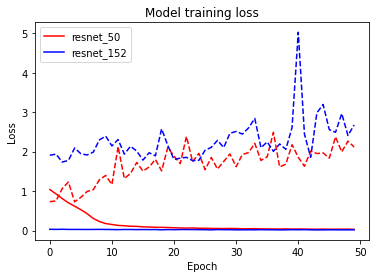

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r')
plt.plot(history_152.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r--')
plt.plot(history_152.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_152'], loc='upper left')
plt.show()

In [72]:
plain_50 = build_resnet(is_50=True, is_plain=True)
plain_50.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
block0_0_conv0 (Conv2D)      (None, 8, 8, 64)          4160      
_________________________________________________________________
block0_0_bn0 (BatchNormaliza (None, 8, 8, 64)          256 

In [74]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_50_plain = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 62/290 [=====>........................] - ETA: 12s - loss: 0.8848 - accuracy: 0.5111

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 11s - loss: 0.8694 - accuracy: 0.5108

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 11s - loss: 0.8549 - accuracy: 0.5120

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 10s - loss: 0.8316 - accuracy: 0.5095

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 5s - loss: 0.7564 - accuracy: 0.5042

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 4s - loss: 0.7515 - accuracy: 0.5036

212/290 [====================>.........] - ETA: 4s - loss: 0.7501 - accuracy: 0.5021

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.7417 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.7350 - accuracy: 0.5002

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 35s 83ms/step - loss: 0.7348 - accuracy: 0.5002 - val_loss: 0.6917 - val_accuracy: 0.5323
Epoch 2/50
 62/290 [=====>........................] - ETA: 15s - loss: 0.6937 - accuracy: 0.4907

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 15s - loss: 0.6937 - accuracy: 0.4903

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 15s - loss: 0.6936 - accuracy: 0.4890

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 14s - loss: 0.6935 - accuracy: 0.4978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 6s - loss: 0.6932 - accuracy: 0.5072

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 5s - loss: 0.6931 - accuracy: 0.5080

213/290 [=====================>........] - ETA: 4s - loss: 0.6931 - accuracy: 0.5075

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5070

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5068

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 85ms/step - loss: 0.6931 - accuracy: 0.5068 - val_loss: 0.6937 - val_accuracy: 0.4848


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/50
 64/290 [=====>........................] - ETA: 11s - loss: 0.6933 - accuracy: 0.4995

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 11s - loss: 0.6933 - accuracy: 0.4991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 11s - loss: 0.6934 - accuracy: 0.4975

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 0.6933 - accuracy: 0.4986

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 5s - loss: 0.6930 - accuracy: 0.5077

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 0.6929 - accuracy: 0.5094

213/290 [=====================>........] - ETA: 3s - loss: 0.6930 - accuracy: 0.5095

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5071

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5059

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6937 - val_accuracy: 0.4828


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/50
 63/290 [=====>........................] - ETA: 11s - loss: 0.6934 - accuracy: 0.4926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 11s - loss: 0.6933 - accuracy: 0.4971

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 0.6933 - accuracy: 0.4975

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.6932 - accuracy: 0.5008

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.6931 - accuracy: 0.5036

216/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5031

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5036

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6936 - val_accuracy: 0.4887


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/50
 66/290 [=====>........................] - ETA: 11s - loss: 0.6936 - accuracy: 0.4969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 11s - loss: 0.6935 - accuracy: 0.4960

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 10s - loss: 0.6935 - accuracy: 0.4978

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 0.6935 - accuracy: 0.4991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 0.6932 - accuracy: 0.5040

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.6933 - accuracy: 0.5012

217/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5024

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5012

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5003

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6934 - val_accuracy: 0.4809


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 6/50
 67/290 [=====>........................] - ETA: 11s - loss: 0.6929 - accuracy: 0.4977

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 10s - loss: 0.6928 - accuracy: 0.5019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.6929 - accuracy: 0.5012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 9s - loss: 0.6928 - accuracy: 0.5046

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 0.6931 - accuracy: 0.5025

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5005

218/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5004

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.4992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.4999

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6934 - val_accuracy: 0.4925


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 7/50
 67/290 [=====>........................] - ETA: 11s - loss: 0.6931 - accuracy: 0.5056

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5046

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 0.6928 - accuracy: 0.5044

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 5s - loss: 0.6930 - accuracy: 0.5029

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 4s - loss: 0.6930 - accuracy: 0.5023

217/290 [=====================>........] - ETA: 4s - loss: 0.6930 - accuracy: 0.5019

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5034

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5031

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 25s 86ms/step - loss: 0.6930 - accuracy: 0.5035 - val_loss: 0.6934 - val_accuracy: 0.4757


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 8/50
 68/290 [======>.......................] - ETA: 11s - loss: 0.6931 - accuracy: 0.5115

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5116

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5054

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 0.6932 - accuracy: 0.5021

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5031

219/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5047

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6934 - val_accuracy: 0.4814


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 9/50
 69/290 [======>.......................] - ETA: 10s - loss: 0.6933 - accuracy: 0.4973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4981

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4959

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 0.6932 - accuracy: 0.4934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.4953

220/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.4959

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.4972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4977

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6931 - accuracy: 0.4977 - val_loss: 0.6935 - val_accuracy: 0.4832


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 10/50
 69/290 [======>.......................] - ETA: 10s - loss: 0.6930 - accuracy: 0.5025

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 10s - loss: 0.6930 - accuracy: 0.5043

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.6930 - accuracy: 0.5046

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.6930 - accuracy: 0.5032

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 4s - loss: 0.6930 - accuracy: 0.5009

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5007

220/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5005

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4900


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 11/50
 71/290 [======>.......................] - ETA: 10s - loss: 0.6930 - accuracy: 0.5103

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5064

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5051

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5031

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 0.6931 - accuracy: 0.5055

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5066

221/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5074

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5071

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6937 - val_accuracy: 0.4860


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 12/50
 71/290 [======>.......................] - ETA: 10s - loss: 0.6934 - accuracy: 0.4932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 10s - loss: 0.6934 - accuracy: 0.4966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 0.6933 - accuracy: 0.4981

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4968

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 0.6933 - accuracy: 0.4957

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.6933 - accuracy: 0.4933

223/290 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.4942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.4941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4947

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 84ms/step - loss: 0.6933 - accuracy: 0.4947 - val_loss: 0.6931 - val_accuracy: 0.5323
Epoch 13/50
 73/290 [======>.......................] - ETA: 11s - loss: 0.6932 - accuracy: 0.5011

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 11s - loss: 0.6932 - accuracy: 0.5016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 11s - loss: 0.6932 - accuracy: 0.5020

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5040

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.6932 - accuracy: 0.5018

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5023

224/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5012

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4939


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 14/50
 74/290 [======>.......................] - ETA: 10s - loss: 0.6933 - accuracy: 0.4989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4996

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5005

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 0.6932 - accuracy: 0.4994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5026

224/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5022

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5039

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6931 - accuracy: 0.5030 - val_loss: 0.6942 - val_accuracy: 0.4721
Epoch 15/50
 75/290 [======>.......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5038

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5037 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5023

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 8s - loss: 0.6932 - accuracy: 0.5000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 4s - loss: 0.6932 - accuracy: 0.4944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.4955

225/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.4949

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.4950

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4948

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5213


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 16/50
 76/290 [======>.......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4971 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4982

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 0.6930 - accuracy: 0.5091

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 3s - loss: 0.6930 - accuracy: 0.5079

226/290 [======================>.......] - ETA: 3s - loss: 0.6930 - accuracy: 0.5090

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5074

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6935 - val_accuracy: 0.4839


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 17/50
 77/290 [======>.......................] - ETA: 11s - loss: 0.6932 - accuracy: 0.5004

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4998

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4995

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 4s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5039

227/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5020

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4896


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 18/50
 77/290 [======>.......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4921

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4973

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 0.6932 - accuracy: 0.4975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.4975

229/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.4991

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.4978

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6930 - val_accuracy: 0.5111


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 19/50
 78/290 [=======>......................] - ETA: 13s - loss: 0.6932 - accuracy: 0.4926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 12s - loss: 0.6933 - accuracy: 0.4924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 12s - loss: 0.6932 - accuracy: 0.4950

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 11s - loss: 0.6933 - accuracy: 0.4939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 5s - loss: 0.6931 - accuracy: 0.5039

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 4s - loss: 0.6931 - accuracy: 0.5035

229/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5050

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 88ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6937 - val_accuracy: 0.4851


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 20/50
 80/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5042

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5036

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5032

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 0.6932 - accuracy: 0.5046

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5056

231/290 [======================>.......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5060

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


267/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5036

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4816


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 21/50
 80/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5014

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4980

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 0.6932 - accuracy: 0.4960

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.4965

231/290 [======================>.......] - ETA: 2s - loss: 0.6932 - accuracy: 0.4965

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.4991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6939 - val_accuracy: 0.4885


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 22/50
 82/290 [=======>......................] - ETA: 10s - loss: 0.6933 - accuracy: 0.5011

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 0.6933 - accuracy: 0.5021

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 10s - loss: 0.6933 - accuracy: 0.5013

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5044

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5077

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5054

232/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5053

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5049

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5053

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4894


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 23/50
 82/290 [=======>......................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5050

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5000 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4996

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.4985

233/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.4987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5027

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6943 - val_accuracy: 0.4716


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 24/50
 84/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5050

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5052

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5043 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5077

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5072

235/290 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5059

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


270/290 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5038

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5026

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 82ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5247
Epoch 25/50
 84/290 [=======>......................] - ETA: 13s - loss: 0.6932 - accuracy: 0.5035

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 13s - loss: 0.6932 - accuracy: 0.5016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 13s - loss: 0.6932 - accuracy: 0.5002

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 11s - loss: 0.6932 - accuracy: 0.5001

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 4s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


231/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5039

236/290 [=======================>......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5038

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/290 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5038

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 81ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6938 - val_accuracy: 0.4664


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 26/50
 86/290 [=======>......................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4998

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5005

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5022

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5023

237/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5022

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


273/290 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5017

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5013

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4739


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 27/50
 87/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4993

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4989

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.4978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.4975

238/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.4976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.4985

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4990

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.4787


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 28/50
 88/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4965

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4949

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4954

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5036

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5059

238/290 [=======================>......] - ETA: 2s - loss: 0.6930 - accuracy: 0.5062

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5044

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 74ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4964


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 29/50
 89/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4998

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5025

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5033

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 8s - loss: 0.6931 - accuracy: 0.5057

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 0.6931 - accuracy: 0.5054

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5071

240/290 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5072

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


275/290 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5069

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5073

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 0.6931 - accuracy: 0.5073 - val_loss: 0.6941 - val_accuracy: 0.4721


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 30/50
 90/290 [========>.....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5045

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5031

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5034

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 8s - loss: 0.6932 - accuracy: 0.5063

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5045

240/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5056

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5074

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5068

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6931 - accuracy: 0.5068 - val_loss: 0.6935 - val_accuracy: 0.4952


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 31/50
 91/290 [========>.....................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5003

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4989

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 8s - loss: 0.6933 - accuracy: 0.5008

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5016

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5006

242/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5021

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/290 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5019

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5018

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 80ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6934 - val_accuracy: 0.4823
Epoch 32/50
 92/290 [========>.....................] - ETA: 12s - loss: 0.6931 - accuracy: 0.5110

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 11s - loss: 0.6931 - accuracy: 0.5112

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 11s - loss: 0.6930 - accuracy: 0.5118

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5099

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 3s - loss: 0.6932 - accuracy: 0.5044

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5036

243/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5030

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/290 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.4859


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 33/50
 93/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4896

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4909

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


118/290 [===========>..................] - ETA: 8s - loss: 0.6931 - accuracy: 0.4947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5018

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5011

243/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5002

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/290 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5012

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6935 - val_accuracy: 0.4806


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 34/50
 94/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5047

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5073

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5057

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


118/290 [===========>..................] - ETA: 8s - loss: 0.6932 - accuracy: 0.5037

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5006

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5016

244/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5015

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5016

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6937 - val_accuracy: 0.4802


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 35/50
 95/290 [========>.....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5023

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5067

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 8s - loss: 0.6931 - accuracy: 0.5057

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 8s - loss: 0.6931 - accuracy: 0.5055

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5033

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5049

245/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5048

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5048

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5047

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 74ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6939 - val_accuracy: 0.4703


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 36/50
 96/290 [========>.....................] - ETA: 10s - loss: 0.6930 - accuracy: 0.5088

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5079

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5074

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 8s - loss: 0.6931 - accuracy: 0.5080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5056

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5062

247/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5060

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/290 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5064

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.6931 - accuracy: 0.5062 - val_loss: 0.6934 - val_accuracy: 0.4926


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 37/50
 97/290 [=========>....................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5056

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 10s - loss: 0.6931 - accuracy: 0.5061

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5052

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


121/290 [===========>..................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5059

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.4990

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


242/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.4993

247/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.4987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5006

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 24s 81ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6937 - val_accuracy: 0.4721


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 38/50
 97/290 [=========>....................] - ETA: 13s - loss: 0.6933 - accuracy: 0.4861

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 13s - loss: 0.6933 - accuracy: 0.4868

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 12s - loss: 0.6932 - accuracy: 0.4884

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 11s - loss: 0.6932 - accuracy: 0.4868

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


125/290 [===========>..................] - ETA: 11s - loss: 0.6932 - accuracy: 0.4871

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 4s - loss: 0.6932 - accuracy: 0.4967

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


243/290 [========================>.....] - ETA: 3s - loss: 0.6932 - accuracy: 0.4983

249/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.4989

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4972

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 26s 90ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6933 - val_accuracy: 0.4829


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 39/50
 98/290 [=========>....................] - ETA: 9s - loss: 0.6929 - accuracy: 0.5150

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 9s - loss: 0.6929 - accuracy: 0.5165

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 9s - loss: 0.6928 - accuracy: 0.5170

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


124/290 [===========>..................] - ETA: 8s - loss: 0.6929 - accuracy: 0.5145

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5051

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


244/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5060

250/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5056

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/290 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5077

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6939 - val_accuracy: 0.4774


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 40/50
100/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5030

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5001

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/290 [===========>..................] - ETA: 8s - loss: 0.6933 - accuracy: 0.4997

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.4968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


245/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.4979

251/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.4982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


286/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4977

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4872


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 41/50
101/290 [=========>....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5048

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5057

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5068

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


126/290 [============>.................] - ETA: 8s - loss: 0.6931 - accuracy: 0.5068

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5041

252/290 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


288/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5009

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5049


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 42/50
101/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5017

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


127/290 [============>.................] - ETA: 8s - loss: 0.6931 - accuracy: 0.5030

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5026

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5029

252/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5022

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 78ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4845


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 43/50
103/290 [=========>....................] - ETA: 9s - loss: 0.6930 - accuracy: 0.5103

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 9s - loss: 0.6930 - accuracy: 0.5109

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 8s - loss: 0.6930 - accuracy: 0.5108

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


127/290 [============>.................] - ETA: 8s - loss: 0.6929 - accuracy: 0.5134

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 2s - loss: 0.6930 - accuracy: 0.5100

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5081

254/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5078

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 22s 77ms/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6934 - val_accuracy: 0.4878


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 44/50
102/290 [=========>....................] - ETA: 13s - loss: 0.6932 - accuracy: 0.5032

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 12s - loss: 0.6932 - accuracy: 0.5003

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 12s - loss: 0.6932 - accuracy: 0.5005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


127/290 [============>.................] - ETA: 11s - loss: 0.6932 - accuracy: 0.4985

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


130/290 [============>.................] - ETA: 11s - loss: 0.6932 - accuracy: 0.4993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5010

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.4989

255/290 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.4983

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4981

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 27s 92ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5155


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 45/50
105/290 [=========>....................] - ETA: 10s - loss: 0.6932 - accuracy: 0.5018

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5035

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5030

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


130/290 [============>.................] - ETA: 8s - loss: 0.6932 - accuracy: 0.5036

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5061

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5072

256/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5060

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5067

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 23s 79ms/step - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6938 - val_accuracy: 0.4850


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 46/50
106/290 [=========>....................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5015

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5013

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


117/290 [===========>..................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5008

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


130/290 [============>.................] - ETA: 8s - loss: 0.6932 - accuracy: 0.5040

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5007

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5017

257/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5018

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5024

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd

290/290 [==============================] - 23s 79ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6935 - val_accuracy: 0.4833


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 47/50
107/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4988

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4975

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


119/290 [===========>..................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4974

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


132/290 [============>.................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4988

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.4974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.4979

258/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.4979

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4961

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 78ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5257


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Epoch 48/50
108/290 [==========>...................] - ETA: 9s - loss: 0.6930 - accuracy: 0.5075

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


114/290 [==========>...................] - ETA: 8s - loss: 0.6930 - accuracy: 0.5078

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 8s - loss: 0.6930 - accuracy: 0.5091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


133/290 [============>.................] - ETA: 7s - loss: 0.6930 - accuracy: 0.5080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


237/290 [=======================>......] - ETA: 2s - loss: 0.6930 - accuracy: 0.5092

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5084

259/290 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5078

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5087

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 78ms/step - loss: 0.6930 - accuracy: 0.5087 - val_loss: 0.6936 - val_accuracy: 0.4896


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 49/50
  4/290 [..............................] - ETA: 18s - loss: 0.6941 - accuracy: 0.4766

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4900

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4909

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


120/290 [===========>..................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4896

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


134/290 [============>.................] - ETA: 8s - loss: 0.6933 - accuracy: 0.4904

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


239/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.4904

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.4927

260/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.4927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4933

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 81ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6938 - val_accuracy: 0.4714


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 50/50
  5/290 [..............................] - ETA: 17s - loss: 0.6930 - accuracy: 0.5125

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4908

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


122/290 [===========>..................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4905

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


135/290 [============>.................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4926

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


240/290 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.4938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.4947

260/290 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.4946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4974

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.6932 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.4983


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


In [73]:
plain_34 = build_resnet(is_50=False, is_plain=True)
plain_34.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
block0_0_conv0 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
block0_0_bn0 (BatchNormaliza (None, 8, 8, 64)          256 

In [75]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_34_plain = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 61/290 [=====>........................] - ETA: 11s - loss: 0.7832 - accuracy: 0.4982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 11s - loss: 0.7769 - accuracy: 0.4931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 11s - loss: 0.7729 - accuracy: 0.4972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.7755 - accuracy: 0.4993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


190/290 [==================>...........] - ETA: 4s - loss: 0.7373 - accuracy: 0.5271

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 0.7332 - accuracy: 0.5347

210/290 [====================>.........] - ETA: 3s - loss: 0.7320 - accuracy: 0.5359

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


246/290 [========================>.....] - ETA: 2s - loss: 0.7245 - accuracy: 0.5442

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.5554

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 33s 75ms/step - loss: 0.7145 - accuracy: 0.5554 - val_loss: 0.6500 - val_accuracy: 0.6068


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/50
 61/290 [=====>........................] - ETA: 10s - loss: 0.6448 - accuracy: 0.6209

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/290 [=====>........................] - ETA: 10s - loss: 0.6478 - accuracy: 0.6192

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 9s - loss: 0.6486 - accuracy: 0.6241

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 9s - loss: 0.6446 - accuracy: 0.6290

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 4s - loss: 0.6306 - accuracy: 0.6485

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.6291 - accuracy: 0.6501

212/290 [====================>.........] - ETA: 3s - loss: 0.6290 - accuracy: 0.6505

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 1s - loss: 0.6242 - accuracy: 0.6561

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.6610

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.6193 - accuracy: 0.6610 - val_loss: 0.7538 - val_accuracy: 0.6054


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/50
 63/290 [=====>........................] - ETA: 10s - loss: 0.5719 - accuracy: 0.7133

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 9s - loss: 0.5715 - accuracy: 0.7117 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.5710 - accuracy: 0.7126

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 9s - loss: 0.5699 - accuracy: 0.7146

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/290 [==================>...........] - ETA: 4s - loss: 0.5726 - accuracy: 0.7088

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.5690 - accuracy: 0.7103

214/290 [=====================>........] - ETA: 3s - loss: 0.5683 - accuracy: 0.7101

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 1s - loss: 0.5640 - accuracy: 0.7126

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7146

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 71ms/step - loss: 0.5621 - accuracy: 0.7146 - val_loss: 0.5768 - val_accuracy: 0.6888


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/50
 63/290 [=====>........................] - ETA: 9s - loss: 0.5384 - accuracy: 0.7309 

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 9s - loss: 0.5385 - accuracy: 0.7279

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 9s - loss: 0.5346 - accuracy: 0.7304

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.5314 - accuracy: 0.7347

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


192/290 [==================>...........] - ETA: 4s - loss: 0.5274 - accuracy: 0.7399

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 3s - loss: 0.5260 - accuracy: 0.7405

214/290 [=====================>........] - ETA: 3s - loss: 0.5250 - accuracy: 0.7415

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 1s - loss: 0.5224 - accuracy: 0.7439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.7476

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 70ms/step - loss: 0.5168 - accuracy: 0.7476 - val_loss: 0.7496 - val_accuracy: 0.5911


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/50
 65/290 [=====>........................] - ETA: 10s - loss: 0.4925 - accuracy: 0.7613

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 9s - loss: 0.4912 - accuracy: 0.7619 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 9s - loss: 0.4903 - accuracy: 0.7638

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 9s - loss: 0.4933 - accuracy: 0.7641

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 4s - loss: 0.4843 - accuracy: 0.7684

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.4827 - accuracy: 0.7678

214/290 [=====================>........] - ETA: 3s - loss: 0.4823 - accuracy: 0.7677

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 1s - loss: 0.4848 - accuracy: 0.7668

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.4869 - accuracy: 0.7651

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 71ms/step - loss: 0.4867 - accuracy: 0.7651 - val_loss: 0.6123 - val_accuracy: 0.6641


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 6/50
 65/290 [=====>........................] - ETA: 9s - loss: 0.4728 - accuracy: 0.7824 

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 9s - loss: 0.4740 - accuracy: 0.7812

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 9s - loss: 0.4713 - accuracy: 0.7821

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.4619 - accuracy: 0.7869

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.4547 - accuracy: 0.7908

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.4548 - accuracy: 0.7908

215/290 [=====================>........] - ETA: 3s - loss: 0.4558 - accuracy: 0.7900

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 1s - loss: 0.4545 - accuracy: 0.7897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.7919

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 69ms/step - loss: 0.4510 - accuracy: 0.7919 - val_loss: 0.6353 - val_accuracy: 0.6698
Epoch 7/50
 66/290 [=====>........................] - ETA: 9s - loss: 0.4520 - accuracy: 0.7907

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 9s - loss: 0.4503 - accuracy: 0.7926

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 9s - loss: 0.4440 - accuracy: 0.7965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.4444 - accuracy: 0.7948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 4s - loss: 0.4290 - accuracy: 0.8043

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.4291 - accuracy: 0.8050

217/290 [=====================>........] - ETA: 3s - loss: 0.4295 - accuracy: 0.8044

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.4296 - accuracy: 0.8048

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 74ms/step - loss: 0.4288 - accuracy: 0.8039 - val_loss: 1.2385 - val_accuracy: 0.5638
Epoch 8/50
 70/290 [======>.......................] - ETA: 12s - loss: 0.3833 - accuracy: 0.8337

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 11s - loss: 0.3868 - accuracy: 0.8329

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 11s - loss: 0.3910 - accuracy: 0.8304

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 0.3952 - accuracy: 0.8258

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 5s - loss: 0.3904 - accuracy: 0.8264

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 4s - loss: 0.3910 - accuracy: 0.8255

218/290 [=====================>........] - ETA: 3s - loss: 0.3918 - accuracy: 0.8251

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 0.3907 - accuracy: 0.8247

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8238

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 0.3919 - accuracy: 0.8238 - val_loss: 0.7872 - val_accuracy: 0.7109


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 9/50
 64/290 [=====>........................] - ETA: 9s - loss: 0.3884 - accuracy: 0.8219

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 9s - loss: 0.3935 - accuracy: 0.8200

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.3933 - accuracy: 0.8206

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.3927 - accuracy: 0.8214

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 3s - loss: 0.3789 - accuracy: 0.8334

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 3s - loss: 0.3779 - accuracy: 0.8342

216/290 [=====================>........] - ETA: 3s - loss: 0.3767 - accuracy: 0.8350

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 1s - loss: 0.3767 - accuracy: 0.8342

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.3761 - accuracy: 0.8341 - val_loss: 0.6454 - val_accuracy: 0.7025
Epoch 10/50
 66/290 [=====>........................] - ETA: 9s - loss: 0.3727 - accuracy: 0.8385

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 9s - loss: 0.3702 - accuracy: 0.8390

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 8s - loss: 0.3676 - accuracy: 0.8397

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.3563 - accuracy: 0.8463

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 3s - loss: 0.3503 - accuracy: 0.8497

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.3492 - accuracy: 0.8497

217/290 [=====================>........] - ETA: 3s - loss: 0.3478 - accuracy: 0.8502

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.3424 - accuracy: 0.8508

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8489

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.3467 - accuracy: 0.8489 - val_loss: 0.5963 - val_accuracy: 0.7078
Epoch 11/50
 67/290 [=====>........................] - ETA: 9s - loss: 0.3276 - accuracy: 0.8601

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 9s - loss: 0.3311 - accuracy: 0.8589

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.3348 - accuracy: 0.8574

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 8s - loss: 0.3392 - accuracy: 0.8539

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 3s - loss: 0.3345 - accuracy: 0.8567

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.3348 - accuracy: 0.8568

218/290 [=====================>........] - ETA: 3s - loss: 0.3340 - accuracy: 0.8572

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 0.3270 - accuracy: 0.8599

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8601

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.3265 - accuracy: 0.8601 - val_loss: 0.8050 - val_accuracy: 0.4789


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 12/50
 69/290 [======>.......................] - ETA: 9s - loss: 0.2861 - accuracy: 0.8779

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 8s - loss: 0.2846 - accuracy: 0.8820

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 8s - loss: 0.2835 - accuracy: 0.8831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 8s - loss: 0.2879 - accuracy: 0.8798

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 3s - loss: 0.3122 - accuracy: 0.8658

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.3104 - accuracy: 0.8670

221/290 [=====================>........] - ETA: 2s - loss: 0.3090 - accuracy: 0.8677

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.3094 - accuracy: 0.8667

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.8677

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.3077 - accuracy: 0.8677 - val_loss: 0.6600 - val_accuracy: 0.7219


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 13/50
 67/290 [=====>........................] - ETA: 9s - loss: 0.2860 - accuracy: 0.8806

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.2861 - accuracy: 0.8809

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.2833 - accuracy: 0.8814

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 8s - loss: 0.2888 - accuracy: 0.8811

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 3s - loss: 0.2830 - accuracy: 0.8852

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.2848 - accuracy: 0.8845

222/290 [=====================>........] - ETA: 2s - loss: 0.2854 - accuracy: 0.8841

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.2849 - accuracy: 0.8843

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8842

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.2848 - accuracy: 0.8842 - val_loss: 0.7709 - val_accuracy: 0.7266


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 14/50
 72/290 [======>.......................] - ETA: 9s - loss: 0.2907 - accuracy: 0.8785

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 8s - loss: 0.2934 - accuracy: 0.8758

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.2976 - accuracy: 0.8744

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.2981 - accuracy: 0.8732

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 3s - loss: 0.2863 - accuracy: 0.8811

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 2s - loss: 0.2831 - accuracy: 0.8829

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.2791 - accuracy: 0.8851

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.2779 - accuracy: 0.8849

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.2779 - accuracy: 0.8850 - val_loss: 0.7275 - val_accuracy: 0.6884


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 15/50
 74/290 [======>.......................] - ETA: 8s - loss: 0.2626 - accuracy: 0.8853

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.2622 - accuracy: 0.8859

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.2585 - accuracy: 0.8886

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 7s - loss: 0.2499 - accuracy: 0.8932

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.2471 - accuracy: 0.8962

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.2497 - accuracy: 0.8950

224/290 [======================>.......] - ETA: 2s - loss: 0.2503 - accuracy: 0.8948

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.2483 - accuracy: 0.8959

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.8962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.2466 - accuracy: 0.8962 - val_loss: 0.7206 - val_accuracy: 0.7144
Epoch 16/50
 74/290 [======>.......................] - ETA: 9s - loss: 0.2499 - accuracy: 0.8976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.2533 - accuracy: 0.8962

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.2496 - accuracy: 0.8983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 7s - loss: 0.2452 - accuracy: 0.8985

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.2328 - accuracy: 0.9038

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 2s - loss: 0.2313 - accuracy: 0.9053

224/290 [======================>.......] - ETA: 2s - loss: 0.2307 - accuracy: 0.9054

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.2288 - accuracy: 0.9067

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.2280 - accuracy: 0.9077

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 74ms/step - loss: 0.2276 - accuracy: 0.9079 - val_loss: 1.0377 - val_accuracy: 0.7228


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 17/50
 79/290 [=======>......................] - ETA: 11s - loss: 0.2153 - accuracy: 0.9104

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 0.2161 - accuracy: 0.9113

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 10s - loss: 0.2138 - accuracy: 0.9123

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 10s - loss: 0.2162 - accuracy: 0.9126

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 0.2052 - accuracy: 0.9165

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.2068 - accuracy: 0.9156

220/290 [=====================>........] - ETA: 3s - loss: 0.2063 - accuracy: 0.9159

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.2037 - accuracy: 0.9174

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9152

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 21s 73ms/step - loss: 0.2077 - accuracy: 0.9152 - val_loss: 0.9181 - val_accuracy: 0.7135
Epoch 18/50
 71/290 [======>.......................] - ETA: 8s - loss: 0.2130 - accuracy: 0.9170

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 8s - loss: 0.2085 - accuracy: 0.9191

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.2071 - accuracy: 0.9195

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 7s - loss: 0.2033 - accuracy: 0.9212

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 3s - loss: 0.1960 - accuracy: 0.9230

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.1919 - accuracy: 0.9241

223/290 [======================>.......] - ETA: 2s - loss: 0.1915 - accuracy: 0.9240

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.1876 - accuracy: 0.9259

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9253

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.1870 - accuracy: 0.9255 - val_loss: 1.1001 - val_accuracy: 0.7352


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 19/50
 72/290 [======>.......................] - ETA: 9s - loss: 0.1763 - accuracy: 0.9290

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.1824 - accuracy: 0.9286

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.1797 - accuracy: 0.9294

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 7s - loss: 0.1774 - accuracy: 0.9292

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 3s - loss: 0.1767 - accuracy: 0.9308

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.1765 - accuracy: 0.9307

222/290 [=====================>........] - ETA: 2s - loss: 0.1782 - accuracy: 0.9297

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.1843 - accuracy: 0.9269

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1822 - accuracy: 0.9281

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.1831 - accuracy: 0.9279 - val_loss: 1.0235 - val_accuracy: 0.7053
Epoch 20/50
 74/290 [======>.......................] - ETA: 9s - loss: 0.1722 - accuracy: 0.9337

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.1708 - accuracy: 0.9346

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.1700 - accuracy: 0.9333

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 8s - loss: 0.1721 - accuracy: 0.9324

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 3s - loss: 0.1753 - accuracy: 0.9304

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.1753 - accuracy: 0.9305

223/290 [======================>.......] - ETA: 2s - loss: 0.1745 - accuracy: 0.9309

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.1705 - accuracy: 0.9328

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.1664 - accuracy: 0.9341 - val_loss: 1.3251 - val_accuracy: 0.7287


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 21/50
 74/290 [======>.......................] - ETA: 9s - loss: 0.1939 - accuracy: 0.9246

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.1921 - accuracy: 0.9254

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.1892 - accuracy: 0.9254

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 7s - loss: 0.1864 - accuracy: 0.9249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 3s - loss: 0.1664 - accuracy: 0.9329

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 2s - loss: 0.1657 - accuracy: 0.9332

226/290 [======================>.......] - ETA: 2s - loss: 0.1659 - accuracy: 0.9332

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.1614 - accuracy: 0.9351

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9359

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.1604 - accuracy: 0.9360 - val_loss: 1.1817 - val_accuracy: 0.7057


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 22/50
 75/290 [======>.......................] - ETA: 8s - loss: 0.1513 - accuracy: 0.9371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.1518 - accuracy: 0.9367

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.1486 - accuracy: 0.9377

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 7s - loss: 0.1429 - accuracy: 0.9403

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 0.1432 - accuracy: 0.9430

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 2s - loss: 0.1435 - accuracy: 0.9433

227/290 [======================>.......] - ETA: 2s - loss: 0.1431 - accuracy: 0.9433

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.1405 - accuracy: 0.9448

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9449

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.1414 - accuracy: 0.9449 - val_loss: 1.0227 - val_accuracy: 0.7179


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 23/50
 77/290 [======>.......................] - ETA: 9s - loss: 0.1455 - accuracy: 0.9434

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.1461 - accuracy: 0.9430

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.1438 - accuracy: 0.9434

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 7s - loss: 0.1405 - accuracy: 0.9456

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 0.1458 - accuracy: 0.9440

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 2s - loss: 0.1447 - accuracy: 0.9441

227/290 [======================>.......] - ETA: 2s - loss: 0.1449 - accuracy: 0.9438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.1427 - accuracy: 0.9453

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.9460

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.1401 - accuracy: 0.9461 - val_loss: 1.4638 - val_accuracy: 0.7014


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 24/50
 78/290 [=======>......................] - ETA: 8s - loss: 0.1212 - accuracy: 0.9553

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.1193 - accuracy: 0.9567

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.1193 - accuracy: 0.9565

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 7s - loss: 0.1188 - accuracy: 0.9563

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 3s - loss: 0.1208 - accuracy: 0.9558

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 2s - loss: 0.1203 - accuracy: 0.9558

229/290 [======================>.......] - ETA: 2s - loss: 0.1202 - accuracy: 0.9560

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.1211 - accuracy: 0.9551

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9555

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.1211 - accuracy: 0.9555 - val_loss: 1.0983 - val_accuracy: 0.7034


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 25/50
 79/290 [=======>......................] - ETA: 8s - loss: 0.1383 - accuracy: 0.9460

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.1386 - accuracy: 0.9456

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.1401 - accuracy: 0.9445

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 7s - loss: 0.1425 - accuracy: 0.9433

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.1538 - accuracy: 0.9403

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 2s - loss: 0.1550 - accuracy: 0.9396

230/290 [======================>.......] - ETA: 2s - loss: 0.1540 - accuracy: 0.9401

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 0s - loss: 0.1563 - accuracy: 0.9396

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9398

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.1543 - accuracy: 0.9398 - val_loss: 1.0117 - val_accuracy: 0.7221
Epoch 26/50
 79/290 [=======>......................] - ETA: 8s - loss: 0.1332 - accuracy: 0.9466

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.1313 - accuracy: 0.9478

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.1335 - accuracy: 0.9469

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 7s - loss: 0.1412 - accuracy: 0.9451

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.1307 - accuracy: 0.9492

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 2s - loss: 0.1293 - accuracy: 0.9501

239/290 [=======================>......] - ETA: 2s - loss: 0.1287 - accuracy: 0.9504

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 0.1257 - accuracy: 0.9518

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9524

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.1246 - accuracy: 0.9525 - val_loss: 0.9654 - val_accuracy: 0.7266
Epoch 27/50
 72/290 [======>.......................] - ETA: 8s - loss: 0.1547 - accuracy: 0.9431

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 8s - loss: 0.1518 - accuracy: 0.9439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.1466 - accuracy: 0.9466

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 7s - loss: 0.1383 - accuracy: 0.9496

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 3s - loss: 0.1268 - accuracy: 0.9537

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 2s - loss: 0.1261 - accuracy: 0.9537

225/290 [======================>.......] - ETA: 2s - loss: 0.1259 - accuracy: 0.9538

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.1210 - accuracy: 0.9557

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9567

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.1189 - accuracy: 0.9568 - val_loss: 3.8476 - val_accuracy: 0.7038
Epoch 28/50
 74/290 [======>.......................] - ETA: 8s - loss: 0.0915 - accuracy: 0.9666

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.0916 - accuracy: 0.9664

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.0902 - accuracy: 0.9673

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 7s - loss: 0.0913 - accuracy: 0.9672

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 3s - loss: 0.1100 - accuracy: 0.9578

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 2s - loss: 0.1089 - accuracy: 0.9581

224/290 [======================>.......] - ETA: 2s - loss: 0.1076 - accuracy: 0.9588

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.1052 - accuracy: 0.9600

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9599

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.1055 - accuracy: 0.9599 - val_loss: 1.4814 - val_accuracy: 0.7498
Epoch 29/50
 73/290 [======>.......................] - ETA: 8s - loss: 0.0908 - accuracy: 0.9648

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.0925 - accuracy: 0.9639

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.0948 - accuracy: 0.9635

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 7s - loss: 0.0986 - accuracy: 0.9616

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 3s - loss: 0.0871 - accuracy: 0.9665

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 2s - loss: 0.0883 - accuracy: 0.9659

225/290 [======================>.......] - ETA: 2s - loss: 0.0885 - accuracy: 0.9659

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.0890 - accuracy: 0.9663

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9638

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 64ms/step - loss: 0.0957 - accuracy: 0.9638 - val_loss: 2.2118 - val_accuracy: 0.6824
Epoch 30/50
 75/290 [======>.......................] - ETA: 8s - loss: 0.1626 - accuracy: 0.9367

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 8s - loss: 0.1592 - accuracy: 0.9375

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.1573 - accuracy: 0.9379

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 7s - loss: 0.1515 - accuracy: 0.9400

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 0.1236 - accuracy: 0.9522

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 2s - loss: 0.1215 - accuracy: 0.9534

228/290 [======================>.......] - ETA: 2s - loss: 0.1209 - accuracy: 0.9536

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.1177 - accuracy: 0.9547

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1128 - accuracy: 0.9566

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.1131 - accuracy: 0.9566 - val_loss: 1.1837 - val_accuracy: 0.7118
Epoch 31/50
 76/290 [======>.......................] - ETA: 8s - loss: 0.0778 - accuracy: 0.9716

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.0788 - accuracy: 0.9714

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.0827 - accuracy: 0.9707

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 7s - loss: 0.0879 - accuracy: 0.9684

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.0904 - accuracy: 0.9663

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 2s - loss: 0.0897 - accuracy: 0.9665

228/290 [======================>.......] - ETA: 2s - loss: 0.0901 - accuracy: 0.9664

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0944 - accuracy: 0.9650

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9646

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.0953 - accuracy: 0.9646 - val_loss: 1.1018 - val_accuracy: 0.6944
Epoch 32/50
 78/290 [=======>......................] - ETA: 8s - loss: 0.1304 - accuracy: 0.9527

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.1282 - accuracy: 0.9535

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.1274 - accuracy: 0.9535

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 7s - loss: 0.1264 - accuracy: 0.9534

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 3s - loss: 0.1151 - accuracy: 0.9570

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 2s - loss: 0.1171 - accuracy: 0.9561

228/290 [======================>.......] - ETA: 2s - loss: 0.1179 - accuracy: 0.9559

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.1180 - accuracy: 0.9567

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.1169 - accuracy: 0.9574

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 64ms/step - loss: 0.1167 - accuracy: 0.9574 - val_loss: 0.9670 - val_accuracy: 0.7248
Epoch 33/50
 78/290 [=======>......................] - ETA: 8s - loss: 0.0889 - accuracy: 0.9667

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.0889 - accuracy: 0.9671

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.0884 - accuracy: 0.9675

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 7s - loss: 0.0869 - accuracy: 0.9686

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 3s - loss: 0.0783 - accuracy: 0.9720

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 2s - loss: 0.0779 - accuracy: 0.9719

230/290 [======================>.......] - ETA: 2s - loss: 0.0778 - accuracy: 0.9719

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 0s - loss: 0.0774 - accuracy: 0.9718

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9717

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 64ms/step - loss: 0.0776 - accuracy: 0.9717 - val_loss: 0.9857 - val_accuracy: 0.7560
Epoch 34/50
 80/290 [=======>......................] - ETA: 8s - loss: 0.0864 - accuracy: 0.9694

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.0837 - accuracy: 0.9705

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 8s - loss: 0.0845 - accuracy: 0.9702

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 7s - loss: 0.0804 - accuracy: 0.9712

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 3s - loss: 0.0770 - accuracy: 0.9715

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/290 [======================>.......] - ETA: 2s - loss: 0.0769 - accuracy: 0.9717

230/290 [======================>.......] - ETA: 2s - loss: 0.0765 - accuracy: 0.9719

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 0s - loss: 0.0790 - accuracy: 0.9714

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0804 - accuracy: 0.9707

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.0804 - accuracy: 0.9707 - val_loss: 1.3364 - val_accuracy: 0.7206
Epoch 35/50
 80/290 [=======>......................] - ETA: 8s - loss: 0.0772 - accuracy: 0.9698

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.0766 - accuracy: 0.9703

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.0789 - accuracy: 0.9692

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 7s - loss: 0.0788 - accuracy: 0.9693 ETA: 7s - loss: 0.0785 - accuracy: 0.96

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 0.0747 - accuracy: 0.9714

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


241/290 [=======================>......] - ETA: 2s - loss: 0.0777 - accuracy: 0.9702

245/290 [========================>.....] - ETA: 2s - loss: 0.0781 - accuracy: 0.9702

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/290 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9699

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9703

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 23s 79ms/step - loss: 0.0785 - accuracy: 0.9703 - val_loss: 1.5673 - val_accuracy: 0.7281
Epoch 36/50
 65/290 [=====>........................] - ETA: 9s - loss: 0.0752 - accuracy: 0.9721

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 9s - loss: 0.0764 - accuracy: 0.9718

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 8s - loss: 0.0751 - accuracy: 0.9722

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.0766 - accuracy: 0.9722

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 3s - loss: 0.0779 - accuracy: 0.9716

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.0773 - accuracy: 0.9721

216/290 [=====================>........] - ETA: 3s - loss: 0.0766 - accuracy: 0.9723

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/290 [=========================>....] - ETA: 1s - loss: 0.0748 - accuracy: 0.9728

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9736

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.0731 - accuracy: 0.9736 - val_loss: 2.0918 - val_accuracy: 0.7569
Epoch 37/50
 67/290 [=====>........................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9797

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/290 [======>.......................] - ETA: 8s - loss: 0.0597 - accuracy: 0.9798

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 8s - loss: 0.0606 - accuracy: 0.9794

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.0588 - accuracy: 0.9797

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 3s - loss: 0.0606 - accuracy: 0.9786

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.0592 - accuracy: 0.9789

218/290 [=====================>........] - ETA: 2s - loss: 0.0595 - accuracy: 0.9788

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 0.0607 - accuracy: 0.9783

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9781

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.0598 - accuracy: 0.9781 - val_loss: 1.3693 - val_accuracy: 0.7356
Epoch 38/50
 67/290 [=====>........................] - ETA: 9s - loss: 0.0537 - accuracy: 0.9825

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 8s - loss: 0.0550 - accuracy: 0.9818

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.0552 - accuracy: 0.9816

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 7s - loss: 0.0574 - accuracy: 0.9811

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 3s - loss: 0.0725 - accuracy: 0.9736

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.0710 - accuracy: 0.9737

219/290 [=====================>........] - ETA: 2s - loss: 0.0710 - accuracy: 0.9738

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.0709 - accuracy: 0.9739

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9739

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.0718 - accuracy: 0.9739 - val_loss: 1.3471 - val_accuracy: 0.7153
Epoch 39/50
 68/290 [======>.......................] - ETA: 9s - loss: 0.0528 - accuracy: 0.9812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 8s - loss: 0.0518 - accuracy: 0.9816

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.0507 - accuracy: 0.9822

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 7s - loss: 0.0494 - accuracy: 0.9820

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 3s - loss: 0.0502 - accuracy: 0.9821

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.0501 - accuracy: 0.9823

221/290 [=====================>........] - ETA: 2s - loss: 0.0506 - accuracy: 0.9823

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.0534 - accuracy: 0.9806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9806

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.0532 - accuracy: 0.9806 - val_loss: 1.0104 - val_accuracy: 0.7300
Epoch 40/50
 70/290 [======>.......................] - ETA: 8s - loss: 0.0560 - accuracy: 0.9799

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 8s - loss: 0.0639 - accuracy: 0.9772

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.0643 - accuracy: 0.9762

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 7s - loss: 0.0640 - accuracy: 0.9764

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 3s - loss: 0.0681 - accuracy: 0.9752

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.0688 - accuracy: 0.9750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.0659 - accuracy: 0.9759

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.9770

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.0637 - accuracy: 0.9770 - val_loss: 3.1054 - val_accuracy: 0.6998
Epoch 41/50
 71/290 [======>.......................] - ETA: 8s - loss: 0.0493 - accuracy: 0.9824

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 8s - loss: 0.0513 - accuracy: 0.9821

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 8s - loss: 0.0518 - accuracy: 0.9816

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 7s - loss: 0.0540 - accuracy: 0.9803

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 3s - loss: 0.0619 - accuracy: 0.9776

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 2s - loss: 0.0606 - accuracy: 0.9780

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.0622 - accuracy: 0.9776

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9761

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 64ms/step - loss: 0.0656 - accuracy: 0.9761 - val_loss: 10.7874 - val_accuracy: 0.4655
Epoch 42/50
 72/290 [======>.......................] - ETA: 8s - loss: 0.0852 - accuracy: 0.9701

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 8s - loss: 0.0835 - accuracy: 0.9702

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.0840 - accuracy: 0.9699

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 7s - loss: 0.0781 - accuracy: 0.9715

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 3s - loss: 0.0688 - accuracy: 0.9758

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 2s - loss: 0.0691 - accuracy: 0.9757

223/290 [======================>.......] - ETA: 2s - loss: 0.0679 - accuracy: 0.9761

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.0677 - accuracy: 0.9761

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9775

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.0638 - accuracy: 0.9775 - val_loss: 1.6843 - val_accuracy: 0.7461
Epoch 43/50
 72/290 [======>.......................] - ETA: 8s - loss: 0.0604 - accuracy: 0.9779

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9784

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.0584 - accuracy: 0.9790

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 7s - loss: 0.0571 - accuracy: 0.9792

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.0556 - accuracy: 0.9798

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 2s - loss: 0.0544 - accuracy: 0.9801

225/290 [======================>.......] - ETA: 2s - loss: 0.0543 - accuracy: 0.9803

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.0546 - accuracy: 0.9801

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9804

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.0531 - accuracy: 0.9804 - val_loss: 2.5158 - val_accuracy: 0.6790


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 44/50
 72/290 [======>.......................] - ETA: 9s - loss: 0.0616 - accuracy: 0.9776

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.0619 - accuracy: 0.9770

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 8s - loss: 0.0607 - accuracy: 0.9778

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.0640 - accuracy: 0.9781

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 2s - loss: 0.0629 - accuracy: 0.9785

237/290 [=======================>......] - ETA: 2s - loss: 0.0632 - accuracy: 0.9784

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/290 [===========================>..] - ETA: 0s - loss: 0.0598 - accuracy: 0.9795

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9793

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 0.0598 - accuracy: 0.9793 - val_loss: 2.6219 - val_accuracy: 0.7144


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 45/50
 74/290 [======>.......................] - ETA: 8s - loss: 0.0587 - accuracy: 0.9767

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.0582 - accuracy: 0.9765

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.0567 - accuracy: 0.9770

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 7s - loss: 0.0550 - accuracy: 0.9778

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


204/290 [====================>.........] - ETA: 3s - loss: 0.0533 - accuracy: 0.9793

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 2s - loss: 0.0525 - accuracy: 0.9800

224/290 [======================>.......] - ETA: 2s - loss: 0.0523 - accuracy: 0.9802

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.0521 - accuracy: 0.9806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9812

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 64ms/step - loss: 0.0511 - accuracy: 0.9812 - val_loss: 1.0464 - val_accuracy: 0.7511
Epoch 46/50
 74/290 [======>.......................] - ETA: 8s - loss: 0.0440 - accuracy: 0.9829

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.0427 - accuracy: 0.9836

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.0416 - accuracy: 0.9842

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 7s - loss: 0.0422 - accuracy: 0.9841

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 0.0421 - accuracy: 0.9844

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 2s - loss: 0.0417 - accuracy: 0.9843

227/290 [======================>.......] - ETA: 2s - loss: 0.0416 - accuracy: 0.9844

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 0.0402 - accuracy: 0.9848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9846

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.0406 - accuracy: 0.9846 - val_loss: 1.7966 - val_accuracy: 0.7166
Epoch 47/50
 76/290 [======>.......................] - ETA: 8s - loss: 0.0414 - accuracy: 0.9842

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.0429 - accuracy: 0.9836

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.0425 - accuracy: 0.9840

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 7s - loss: 0.0417 - accuracy: 0.9845

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 3s - loss: 0.0412 - accuracy: 0.9849

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 2s - loss: 0.0406 - accuracy: 0.9851

229/290 [======================>.......] - ETA: 2s - loss: 0.0399 - accuracy: 0.9853

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.0400 - accuracy: 0.9858

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9855

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 63ms/step - loss: 0.0405 - accuracy: 0.9855 - val_loss: 1.6513 - val_accuracy: 0.6690
Epoch 48/50
 78/290 [=======>......................] - ETA: 8s - loss: 0.0415 - accuracy: 0.9850

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.0406 - accuracy: 0.9851

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.0384 - accuracy: 0.9861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 7s - loss: 0.0396 - accuracy: 0.9854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 3s - loss: 0.0399 - accuracy: 0.9865

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 2s - loss: 0.0401 - accuracy: 0.9865

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.0396 - accuracy: 0.9864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.9859

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.0418 - accuracy: 0.9859 - val_loss: 1.1511 - val_accuracy: 0.7161
Epoch 49/50
 78/290 [=======>......................] - ETA: 8s - loss: 0.0714 - accuracy: 0.9759

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.0701 - accuracy: 0.9763

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.0694 - accuracy: 0.9768

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 7s - loss: 0.0649 - accuracy: 0.9789

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.0564 - accuracy: 0.9811

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 2s - loss: 0.0563 - accuracy: 0.9810

230/290 [======================>.......] - ETA: 2s - loss: 0.0563 - accuracy: 0.9811

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


267/290 [==========================>...] - ETA: 0s - loss: 0.0548 - accuracy: 0.9815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9815

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 64ms/step - loss: 0.0541 - accuracy: 0.9815 - val_loss: 1.9842 - val_accuracy: 0.7228
Epoch 50/50
 81/290 [=======>......................] - ETA: 8s - loss: 0.0368 - accuracy: 0.9859

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.0353 - accuracy: 0.9867

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 7s - loss: 0.0355 - accuracy: 0.9866

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 7s - loss: 0.0363 - accuracy: 0.9860

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.0351 - accuracy: 0.9862

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 2s - loss: 0.0348 - accuracy: 0.9864

231/290 [======================>.......] - ETA: 2s - loss: 0.0350 - accuracy: 0.9864

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 0s - loss: 0.0385 - accuracy: 0.9852

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 18s 64ms/step - loss: 0.0384 - accuracy: 0.9853 - val_loss: 1.1378 - val_accuracy: 0.6871


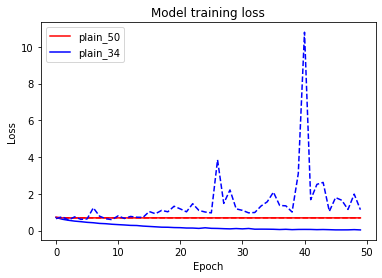

In [76]:
import matplotlib.pyplot as plt

plt.plot(history_50_plain.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.plot(history_50_plain.history['val_loss'], 'r--')
plt.plot(history_34_plain.history['val_loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_50', 'plain_34'], loc='upper left')
plt.show()

## 회고  
- summary 정보를 참고하여 resnet_50, resnet_34 모델을  레퍼런스 모델들과 동일한 형태로 구축해 보았습니다. 
- summary 내용으로 판단해 봤을 때는 이상한 부분을 찾지 못했으니 실제 학습결과 학습이 원활히 진행되지는 않았으며, loss 또한 34 보다 50모델이 더 크게 나왔습니다.  
- 참고를 위해 keras에서 지원하는 resnet50 모델과, resnet152 모델을 가져와서 학습을 해 본 결과 training set에서는 resnet152의 loss가 더 빨리 떨어지는 것을 확인했으나, validation set에서는 resnet50과 resnet152 모두 안정적인 결과를 보여주지는 못했습니다.   
- plain 모델 또한 resnet 모델과 비교하기 위해 build하여 학습을 수행했으나, resnet 모델과 동일하게 안정적인 결과를 보여주지 못했습니다.  
- 문제의 원인을 찾아 추가 개선이 필요하기에 일단 안정적인 결과가 나올 것으로 예상되는 imagenet 데이터로 다시 수행해보고 추가 개선을 추후 수행해 보도록 하겠습니다.    

[참고]  
- https://hwanny-yy.tistory.com/12  
- https://github.com/tensorpack/tensorpack/blob/master/examples/ResNet/resnet_model.py